In [ ]:
!pip install pandas-summary -qq
!pip install optuna -qq
!pip install lightgbm -qq
!pip install shap -qq

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime as dt
from pandas_summary import DataFrameSummary

data_path = Path("/content/data")
files = os.listdir(data_path)
print("[INFO] Found files:", files)
print("[INFO] Number of files found", len(files))

[INFO] Found files: ['ml_case_training_output.csv', 'ml_case_training_data.csv', 'ml_case_training_hist_data.csv']
[INFO] Number of files found 3


In [ ]:
# training labels
out_df = pd.read_csv(data_path/'ml_case_training_output.csv')
out_df.head()

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1
2,d29c2c54acc38ff3c0614d0a653813dd,0
3,764c75f661154dac3a6c254cd082ea7d,0
4,bba03439a292a1e166f80264c16191cb,0


In [ ]:
# price history
hist_df = pd.read_csv(data_path/'ml_case_training_hist_data.csv')
hist_df.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [ ]:
# customer data
df = pd.read_csv(data_path/'ml_case_training_data.csv')
df = df.merge(out_df, on="id")
df.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaN,2015-06-23,NaN,NaN,NaN,NaN,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,2009-08-21,2015-08-31,NaN,NaN,NaN,NaN,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,2010-04-16,2015-04-17,NaN,NaN,NaN,NaN,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,2010-03-30,2015-03-31,NaN,NaN,NaN,NaN,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


### Data Cleaning

In [ ]:
dfs = DataFrameSummary(hist_df)
dfs.columns_stats

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
counts,193002,193002,191643,191643,191643,191643,191643,191643
uniques,16096,12,1853,1189,711,69,33,30
missing,0,0,1359,1359,1359,1359,1359,1359
missing_perc,0%,0%,0.70%,0.70%,0.70%,0.70%,0.70%,0.70%
types,categorical,categorical,numeric,numeric,numeric,numeric,numeric,numeric


In [ ]:
dfs = DataFrameSummary(df)
dfs.columns_stats

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
counts,16096,6551,0,11878,16096,16096,16096,16096,16094,3508,15939,16056,3508,3508,3508,3508,16096,16096,15970,16096,15970,15970,15970,16096,16096,16083,16083,16096,16081,16096,16009,16093,16096
uniques,16096,419,0,7,12002,2290,5308,1961,371,1133,2307,398,2042,2042,3429,1955,15422,4895,14,3938,617,412,46,2,8765,2979,3006,11,13189,15,5,867,2
missing,0,9545,16096,4218,0,0,0,0,2,12588,157,40,12588,12588,12588,12588,0,0,126,0,126,126,126,0,0,13,13,0,15,0,87,3,0
missing_perc,0%,59.30%,100%,26.21%,0%,0%,0%,0%,0.01%,78.21%,0.98%,0.25%,78.21%,78.21%,78.21%,78.21%,0%,0%,0.78%,0%,0.78%,0.78%,0.78%,0%,0%,0.08%,0.08%,0%,0.09%,0%,0.54%,0.02%,0%
types,unique,categorical,numeric,categorical,numeric,numeric,numeric,categorical,categorical,categorical,categorical,categorical,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,categorical,numeric,bool


Handle Missing Values

- `hist_df` has same amount missing values in all fields except id and price_date. 
    - Replace the null values with median. 
    - Check for outliters if any in prices. To handle outliters, replace outliers with median.
- `df` - It has many missing values in columns. 
    - Remove columns that have missing value >= 70.
    - Fill categorical columns with having NaN values with NONE as a separate category.
    - Convert dates to appropriate date format.
    - Fill missing dates with median.


Feature Engineering

- We create a mean prices for each id.
- To handle dates we can either use a simple datetime transformation or a cyclical datetime transformation.
- Use reference date `01-01-2016` to transform dates in numbers of months from reference date.


In [ ]:
# drop cols having missing value > 70%
dropcols = ['date_first_activ', 'forecast_base_bill_ele', 'forecast_base_bill_year', 'forecast_bill_12m', 'forecast_cons', 'campaign_disc_ele']
df = df.drop(dropcols, axis=1)

In [ ]:
# convert dates to datetime format
df['date_activ'] = pd.to_datetime(df['date_activ'], format='%Y-%m-%d')
df['date_end'] = pd.to_datetime(df['date_end'], format='%Y-%m-%d')
df['date_modif_prod'] = pd.to_datetime(df['date_modif_prod'], format='%Y-%m-%d')
df['date_renewal'] = pd.to_datetime(df['date_renewal'], format='%Y-%m-%d')
hist_df['price_date'] = pd.to_datetime(hist_df['price_date'], format='%Y-%m-%d')

In [ ]:
# handle categorical missing values
cat_cols = ['origin_up', 'activity_new', 'channel_sales', 'has_gas']

for c in cat_cols:
    df.loc[:, c] = df[c].fillna("NONE")

In [ ]:
# handle missing values of dates and prices -> replace with median
hist_df.loc[hist_df['price_p1_var'].isnull(),'price_p1_var'] = hist_df['price_p1_var'].median()
hist_df.loc[hist_df['price_p2_var'].isnull(),'price_p2_var'] = hist_df['price_p2_var'].median()
hist_df.loc[hist_df['price_p3_var'].isnull(),'price_p3_var'] = hist_df['price_p3_var'].median()
hist_df.loc[hist_df['price_p1_fix'].isnull(),'price_p1_fix'] = hist_df['price_p1_fix'].median()
hist_df.loc[hist_df['price_p2_fix'].isnull(),'price_p2_fix'] = hist_df['price_p2_fix'].median()
hist_df.loc[hist_df['price_p3_fix'].isnull(),'price_p3_fix'] = hist_df['price_p3_fix'].median()

df.loc[df['date_end'].isnull(),'date_end'] = df['date_end'].value_counts().index[0]
df.loc[df['date_activ'].isnull(),'date_activ'] = df['date_activ'].value_counts().index[0]
df.loc[df['date_renewal'].isnull(),'date_renewal'] = df['date_renewal'].value_counts().index[0]
df.loc[df['date_modif_prod'].isnull(),'date_modif_prod'] = df['date_modif_prod'].value_counts().index[0]

df.loc[df['forecast_price_energy_p1'].isnull(),'forecast_price_energy_p1'] = df['forecast_price_energy_p1'].median()
df.loc[df['forecast_price_energy_p2'].isnull(),'forecast_price_energy_p2'] = df['forecast_price_energy_p2'].median()
df.loc[df['forecast_price_pow_p1'].isnull(),'forecast_price_pow_p1'] = df['forecast_price_pow_p1'].median()
df.loc[df['margin_gross_pow_ele'].isnull(),'margin_gross_pow_ele'] = df['margin_gross_pow_ele'].median()
df.loc[df['margin_net_pow_ele'].isnull(),'margin_net_pow_ele'] = df['margin_net_pow_ele'].median()
df.loc[df['net_margin'].isnull(),'net_margin'] = df['net_margin'].median()
df.loc[df['pow_max'].isnull(),'pow_max'] = df['pow_max'].median()

In [ ]:
# feature engineering

# how long did customer stay?
df['tenure'] = ((df['date_end'] - df['date_activ'])/np.timedelta64(1,'Y')).astype(int)

# combine fix and var price as one
hist_df['mean_price_p1'] = hist_df['price_p1_var'] + hist_df['price_p1_fix']
hist_df['mean_price_p2'] = hist_df['price_p2_var'] + hist_df['price_p2_fix']
hist_df['mean_price_p3'] = hist_df['price_p3_var'] + hist_df['price_p3_fix']

mean_year = hist_df.groupby(['id']).mean().reset_index()
df = df.merge(mean_year, on="id")

reference_date = dt.datetime(2016,1,1)
df['ref_activ'] = ((reference_date-df['date_activ'])/np.timedelta64(1,'M')).astype(int)
df['ref_end'] = ((reference_date-df['date_end'])/np.timedelta64(1,'M')).astype(int)
df['ref_renewal'] = ((reference_date-df['date_renewal'])/np.timedelta64(1,'M')).astype(int)
df['ref_modif_prod'] = ((reference_date-df['date_modif_prod'])/np.timedelta64(1,'M')).astype(int)

In [ ]:
# all missing values handled
dfs = DataFrameSummary(df)
dfs.columns_stats

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,mean_price_p1,mean_price_p2,mean_price_p3,ref_activ,ref_end,ref_renewal,ref_modif_prod
counts,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,15970,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096,16096
uniques,16096,420,8,12002,2290,5308,1961,371,2307,398,15422,4895,14,3938,617,412,46,2,8765,2979,3006,11,13189,15,6,867,2,15,5279,3212,2390,954,426,421,6555,3521,2709,125,17,30,147
missing,0,0,0,0,0,0,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0.78%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,unique,categorical,categorical,numeric,numeric,numeric,date,date,date,date,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,categorical,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [ ]:
df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,mean_price_p1,mean_price_p2,mean_price_p3,ref_activ,ref_end,ref_renewal,ref_modif_prod
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135955,0.053211,43.539585,196.123447,22.461168,21.459922,1.347788,217.895415,5.030629,20.602873,0.099093,5.329958,0.141022,0.054636,0.030503,43.332458,10.625524,6.411365,43.473480,10.680159,6.441868,58.929858,-6.376615,4.924640,35.741240
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026157,0.048515,5.192262,494.366979,23.691341,27.906076,1.459808,366.583368,1.676101,21.770587,0.298796,1.749248,0.024184,0.049505,0.036016,5.344173,12.756066,7.718995,5.354348,12.795855,7.754309,20.125024,3.633479,3.812127,30.609746
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,-17.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,12.025000,11.950000,1.000000,52.017500,4.000000,12.500000,0.000000,4.000000,0.124068,0.000000,0.000000,40.688156,0.000000,0.000000,40.812330,0.000000,0.000000,44.000000,-9.000000,2.000000,7.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,0.147251,0.085936,0.000000,44.281745,0.000000,0.000000,44.439451,0.086114,0.000000,57.000000,-6.000000,5.000000,29.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.735000,6.000000,19.800000,0.000000,6.000000,0.150171,0.102290,0.072525,44.370635,24.388455,16.248109,44.523618,24.488429,16.320606,71.000000,-3.000000,8.000000,64.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000000,0.278759,0.196275,0.102952,59.444710,36.490692,16.818917,59.723469,36.599861,16.911504,185.000000,112.000000,30.000000,185.000000


In [ ]:
hist_df.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,mean_price_p1,mean_price_p2,mean_price_p3
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.332175,10.622871,6.409981,43.473202,10.677501,6.440477
std,0.025032,0.049924,0.036298,5.419345,12.841899,7.773595,5.429820,12.881679,7.809160
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172,-0.041564,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000,40.847060,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000,44.416485,0.085483,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389,44.588653,24.446744,16.299876
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221,59.725410,36.623647,17.549052


### EDA

Data Transformation, Feature Engineering and visualization.

We will steal some of the plots from BCG eda solution.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (5, 5)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

#https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
def plot_percentage(x, y, data):
    percent_df = (data.groupby([x])[y]
                        .value_counts(normalize=True)
                        .rename('percentage')
                        .mul(100)
                        .reset_index()
                        .sort_values(x))
    p = sns.barplot(x=x, y="percentage", hue=y, data=percent_df)
    _ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
    plt.show()

0    0.900907
1    0.099093
Name: churn, dtype: float64


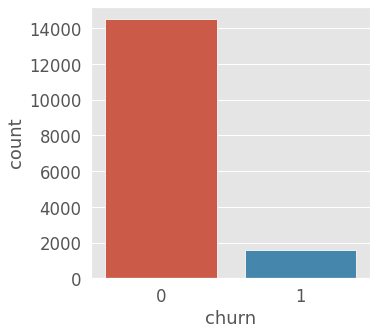

In [ ]:
# 90% retention - 10% churn
print(df["churn"].value_counts(normalize=True))
sns.countplot(data=df, x="churn")

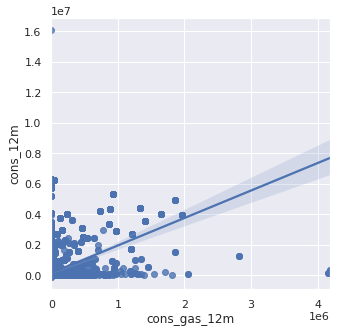

In [ ]:
# linear relationship between energy and gas
sns.set_theme(color_codes=True)
sns.regplot(x="cons_gas_12m", y="cons_12m", data=df)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16]), array([   1,   11, 2757, 4331, 2495, 5054,  648,  202,  106,  113,  236,
        127,   13,    1,    1]))


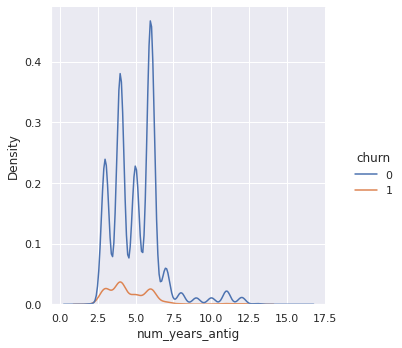

In [ ]:
# more number of years customer is with company less chances of churning
print(np.unique(df['num_years_antig'], return_counts=True))
sns.displot(data=df, x="num_years_antig", hue="churn", kind="kde")

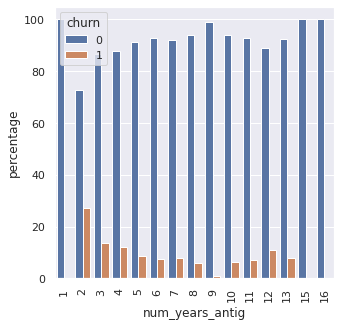

In [ ]:
plot_percentage('num_years_antig', 'churn', df)

(array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 31, 32]), array([12560,  2708,   561,   170,    37,     9,     8,    12,     2,
           4,    25]))


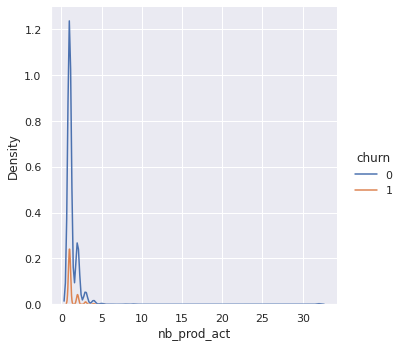

In [ ]:
# having 1,2,3,4 nb_prod_act have more chances of churning
print(np.unique(df['nb_prod_act'], return_counts=True))
sns.displot(data=df, x="nb_prod_act", hue="churn", kind="kde")

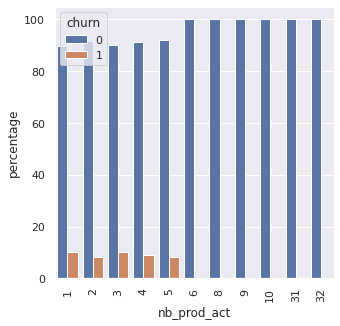

In [ ]:
plot_percentage('nb_prod_act', 'churn', df)

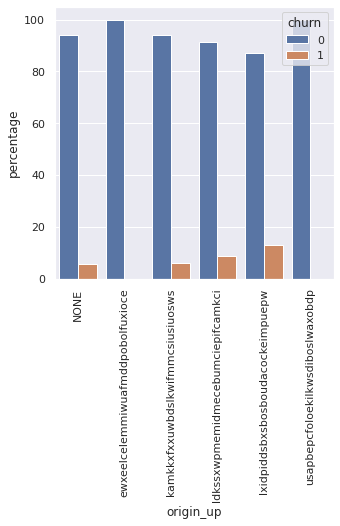

In [ ]:
plot_percentage('origin_up', 'churn', df)

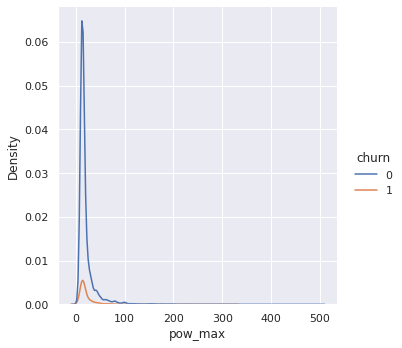

In [ ]:
sns.displot(data=df, x="pow_max", hue="churn", kind="kde")

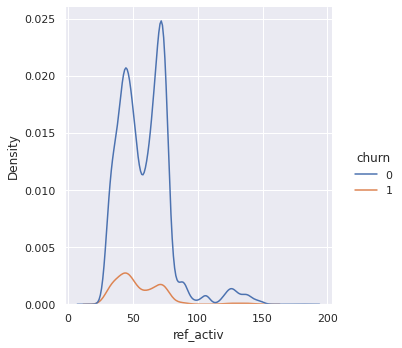

In [ ]:
sns.displot(data=df, x="ref_activ", hue="churn", kind="kde")

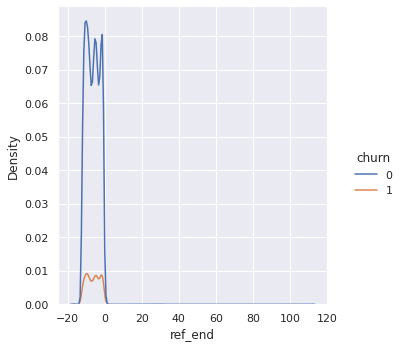

In [ ]:
sns.displot(data=df, x="ref_end", hue="churn", kind="kde")

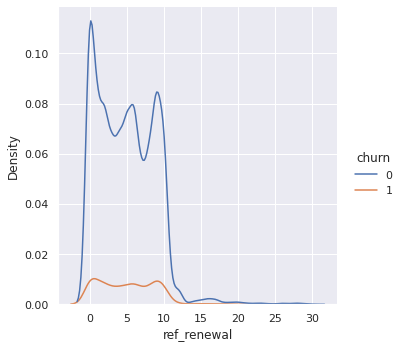

In [ ]:
sns.displot(data=df, x="ref_renewal", hue="churn", kind="kde")

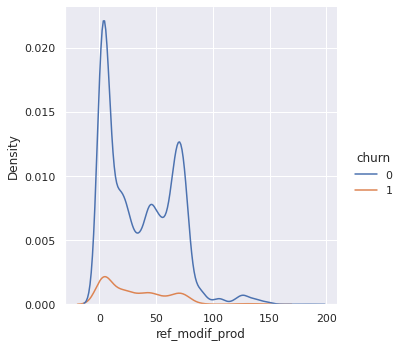

In [ ]:
sns.displot(data=df, x="ref_modif_prod", hue="churn", kind="kde")

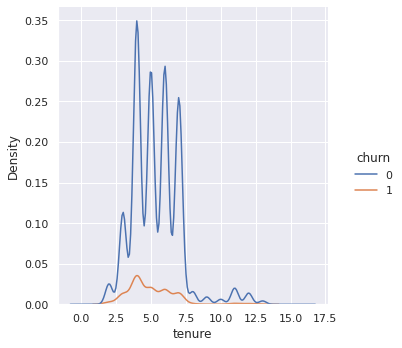

In [ ]:
# same as number_years_antig
sns.displot(data=df, x="tenure", hue="churn", kind="kde")

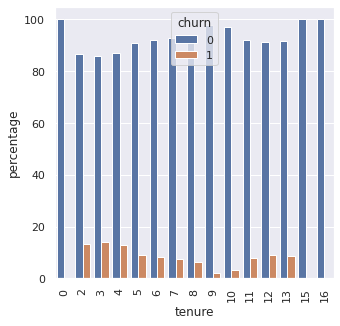

In [ ]:
plot_percentage('tenure', 'churn', df)

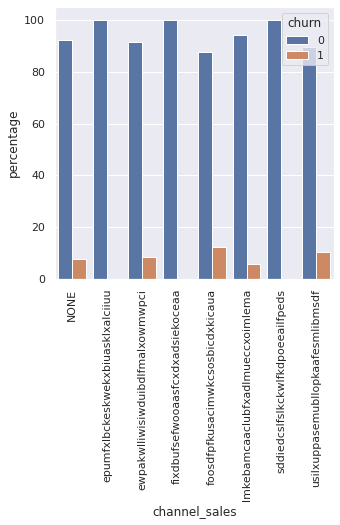

In [ ]:
# some of channels have 100% retention
plot_percentage('channel_sales', 'churn', df)

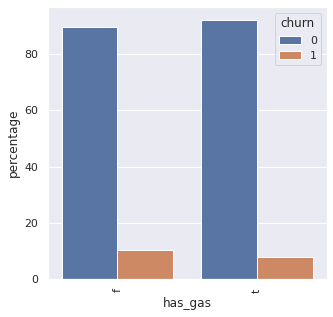

In [ ]:
# having gas has less chances of churning?
plot_percentage('has_gas', 'churn', df)

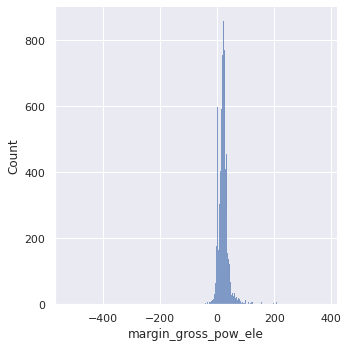

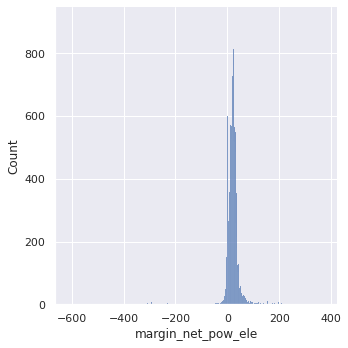

In [ ]:
sns.displot(data=df, x="margin_gross_pow_ele")
sns.displot(data=df, x="margin_net_pow_ele")

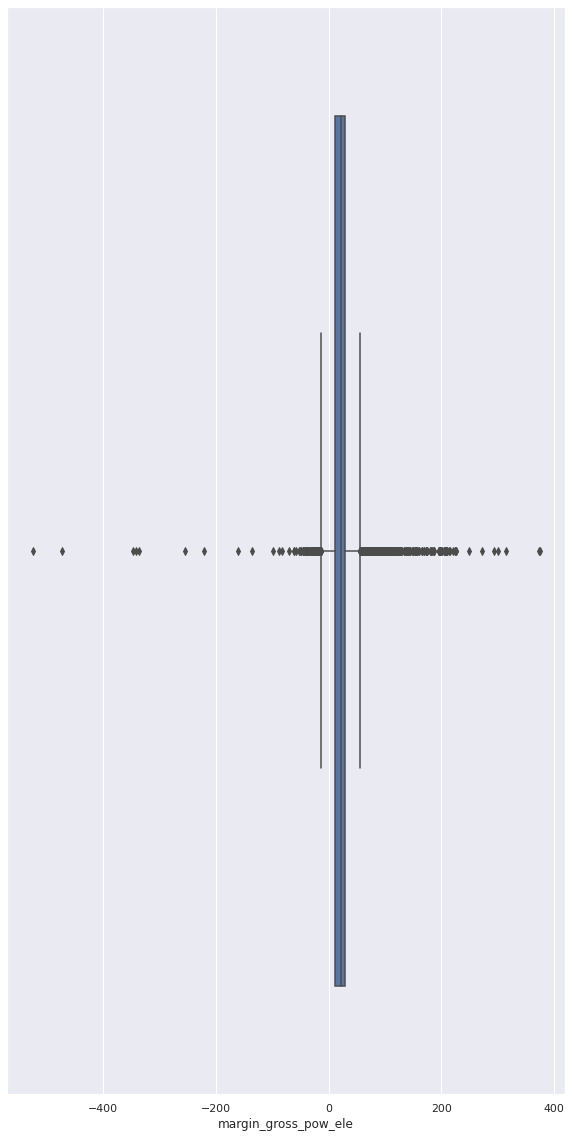

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='margin_gross_pow_ele')

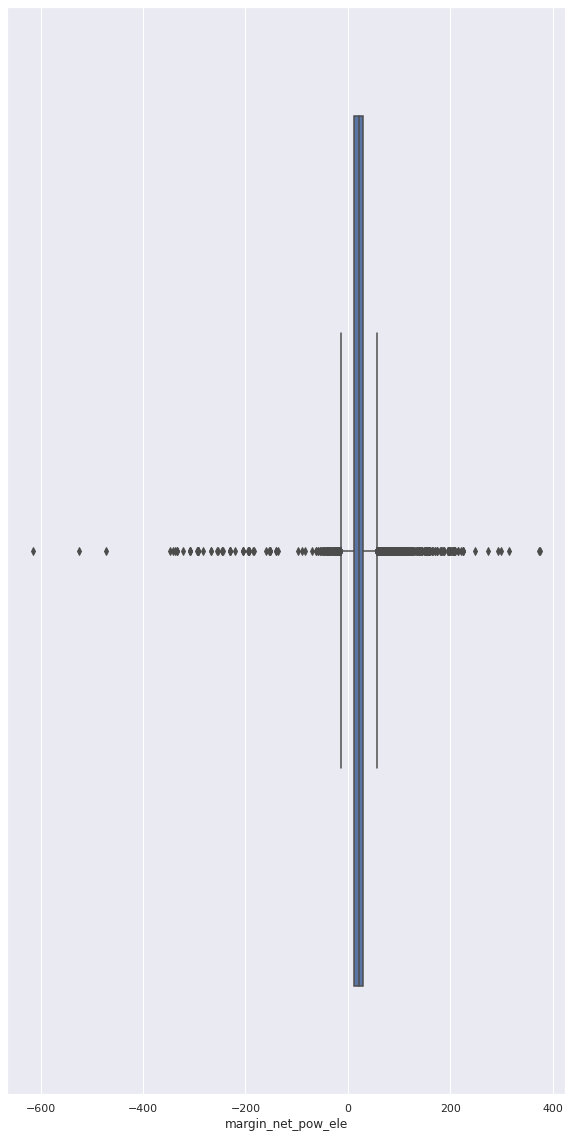

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='margin_net_pow_ele')

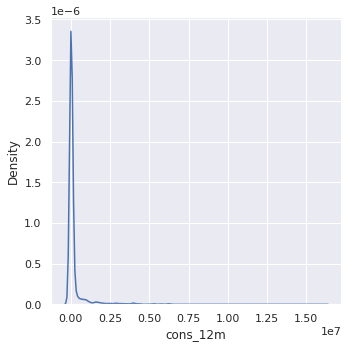

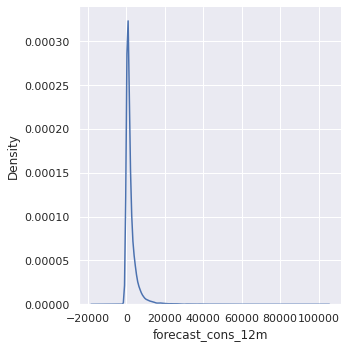

In [ ]:
sns.displot(data=df, x="cons_12m", kind='kde')
sns.displot(data=df, x="forecast_cons_12m", kind='kde')

In the boxplots below we can see that there are many outliers i.e <0 values for different columns

(-20000.0, 100000.0)

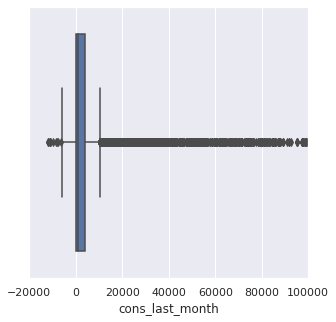

In [ ]:
sns.boxplot(data=df, x='cons_last_month')
plt.xlim(-20000,100000)

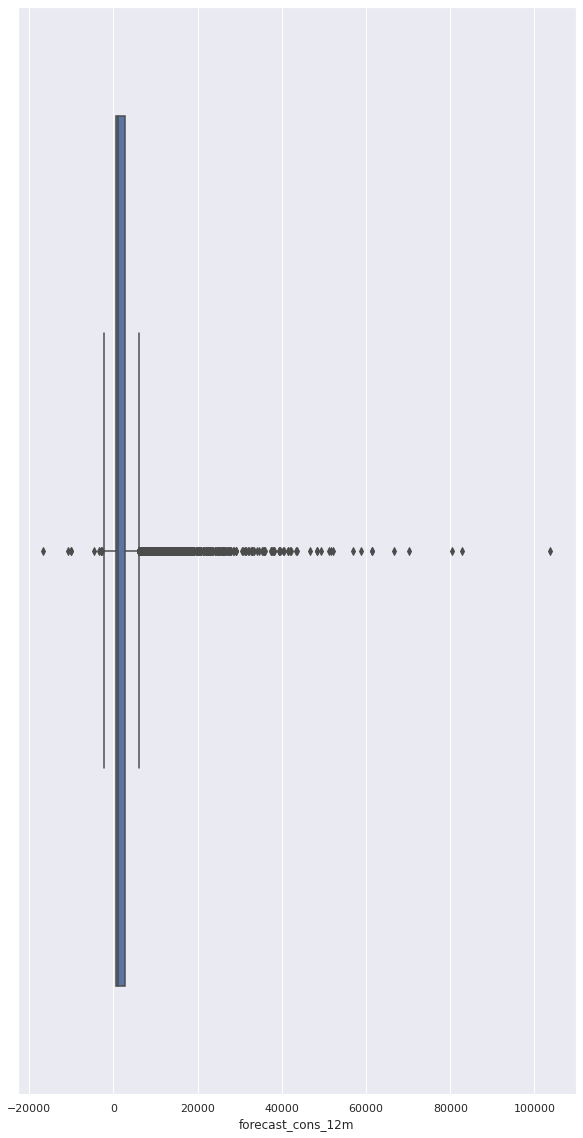

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='forecast_cons_12m')

(-200000.0, 2000000.0)

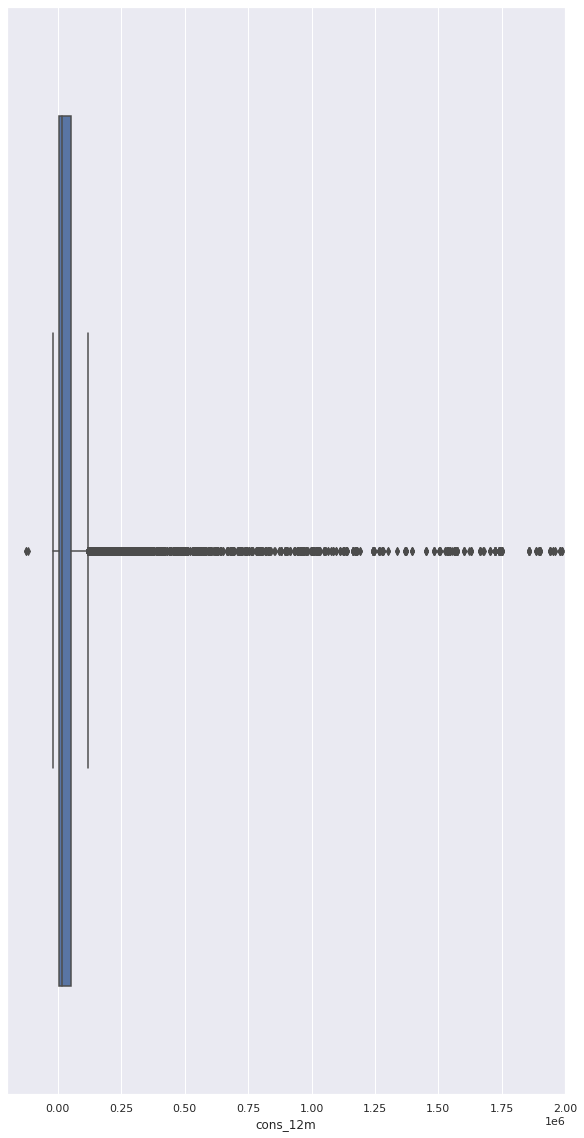

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='cons_12m')
plt.xlim(-200000,2000000)

(-200000.0, 2000000.0)

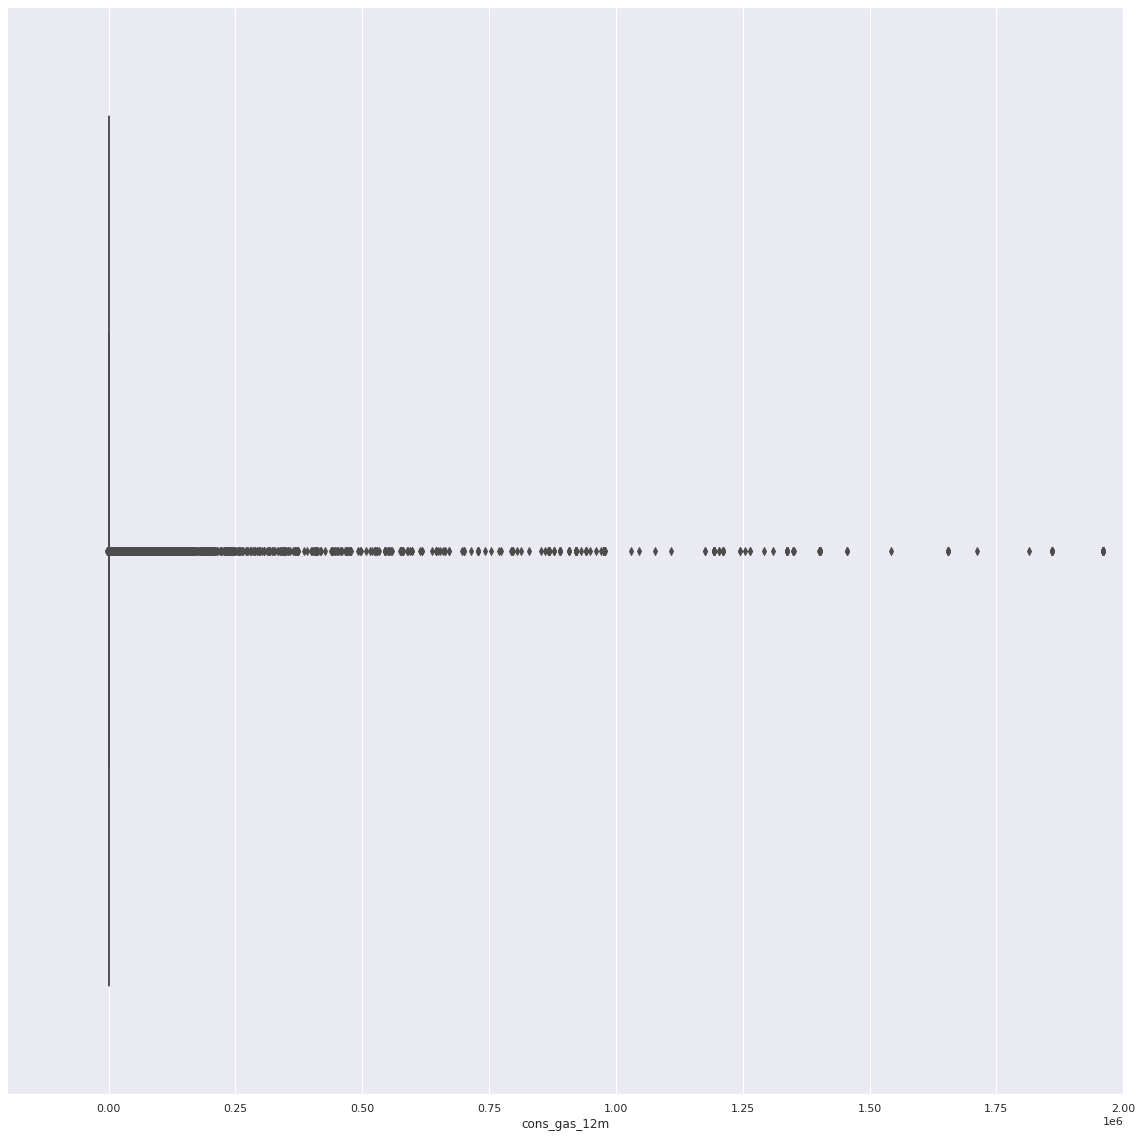

In [ ]:
plt.figure(figsize=(20, 20))
sns.boxplot(data=df, x='cons_gas_12m')
plt.xlim(-200000,2000000)

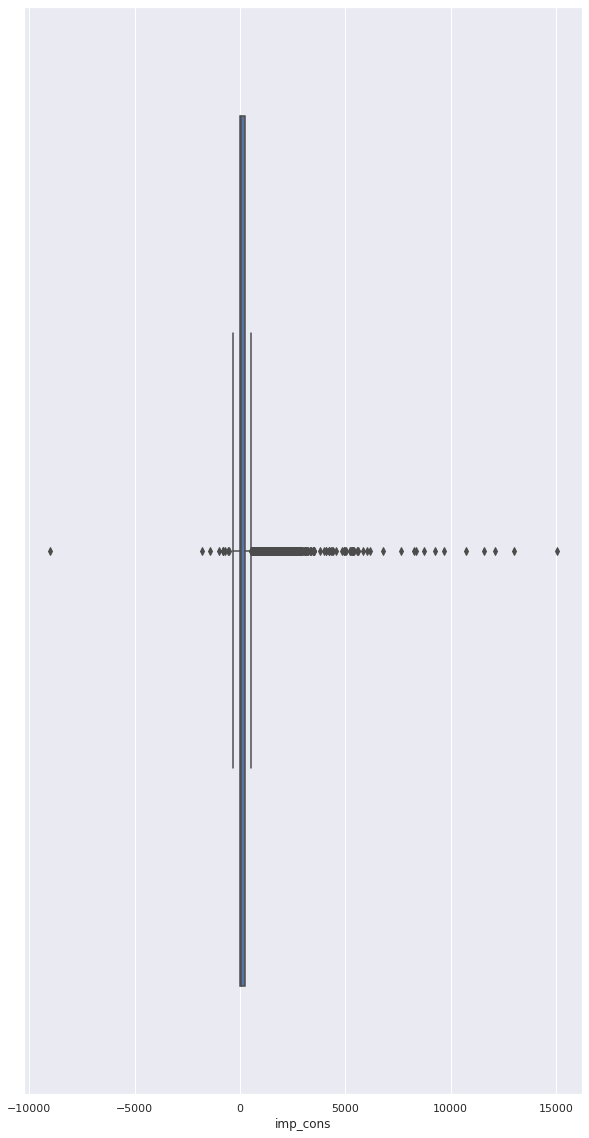

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='imp_cons')

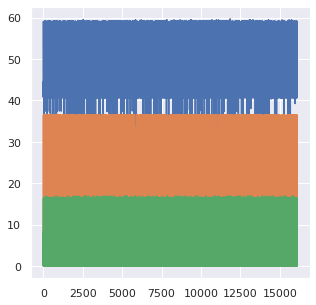

In [ ]:
plt.plot(df['mean_price_p1'])
plt.plot(df['mean_price_p2'])
plt.plot(df['mean_price_p3'])

### Data Transformation

We convert various categorical, numerical columns by applying appropriate transformation for each column.

Correlation Matrix


Here we see that there many features that seem to be correlated with each other.

- has_gas, cons_gas_12m
- imp_cons, forecast_cons_year, forecast_cons_12m
- forecast_price_energy_p1, price_p1_var, price_p1_fix and negatively correlated with price_p2_var, price_p3_var, price_p2_fix, price_p3_fix
- forecast_price_energy_p2, price_p2_var, price_p2_fix, price_p3_var,price_p3_fix
- tenure, num_years_antig


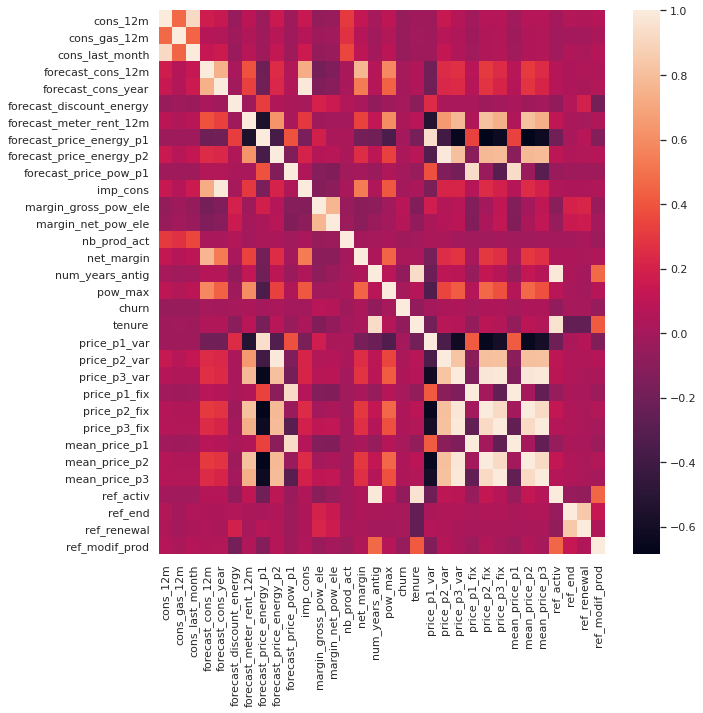

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())

Handle outliers

- `df` contains columns that have outliters and some numerical columns that have missing values (small percentage). We will drop those and handle outliters.

Data Transformation

Here we will transform all columns by applying proper transformation i.e. label encoding for categorical columns, Standard Scaling and Log Transformation for numerical columns

In [ ]:
outliers = ['imp_cons', 'forecast_meter_rent_12m', 'forecast_cons_year', 'forecast_price_pow_p1',
            'forecast_price_energy_p1', 'forecast_price_energy_p2', 'cons_12m', 
            'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'price_p1_var', 'price_p2_var',	
            'price_p3_var',	'price_p1_fix',	'price_p2_fix', 'price_p3_fix',	'mean_price_p1', 
            'mean_price_p2', 'mean_price_p3']

num_cols = ['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max', 
            'ref_activ', 'ref_end', 'ref_renewal', 'ref_modif_prod']


cat_cols = ['activity_new']

dummy_cols = ['origin_up', 'channel_sales', 'has_gas']

In [ ]:
from pandas.api.types import is_numeric_dtype
from typing import List, Union, Any
from datetime import date, datetime
import calendar
import numpy as np
import re
from functools import partial

def ifnone(a:Any,b:Any)->Any:
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def make_date(df, date_field:str):
    "Make sure `df[field_name]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

def cyclic_dt_feat_names(time:bool=True, add_linear:bool=False)->List[str]:
    "Return feature names of date/time cycles as produced by `cyclic_dt_features`."
    fs = ['cos','sin']
    attr = [f'{r}_{f}' for r in 'weekday day_month month_year day_year'.split() for f in fs]
    if time: attr += [f'{r}_{f}' for r in 'hour clock min sec'.split() for f in fs]
    if add_linear: attr.append('year_lin')
    return attr


def cyclic_dt_features(d:Union[date,datetime], time:bool=True, add_linear:bool=False)->List[float]:
    "Calculate the cos and sin of date/time cycles."
    tt,fs = d.timetuple(), [np.cos, np.sin]
    day_year,days_month = tt.tm_yday, calendar.monthrange(d.year, d.month)[1]
    days_year = 366 if calendar.isleap(d.year) else 365
    rs = d.weekday()/7, (d.day-1)/days_month, (d.month-1)/12, (day_year-1)/days_year
    feats = [f(r * 2 * np.pi) for r in rs for f in fs]
    if time and isinstance(d, datetime) and type(d) != date:
        rs = tt.tm_hour/24, tt.tm_hour%12/12, tt.tm_min/60, tt.tm_sec/60
        feats += [f(r * 2 * np.pi) for r in rs for f in fs]
    if add_linear:
        if type(d) == date: feats.append(d.year + rs[-1])
        else:
            secs_in_year = (datetime(d.year+1, 1, 1) - datetime(d.year, 1, 1)).total_seconds()
            feats.append(d.year + ((d - datetime(d.year, 1, 1)).total_seconds() / secs_in_year))
    return feats

## use this function for cyclic features
def add_cyclic_datepart(df, field_name:str, prefix:str=None, drop:bool=True, time:bool=False, add_linear:bool=False):
    "Helper function that adds trigonometric date/time features to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    series = field.apply(partial(cyclic_dt_features, time=time, add_linear=add_linear))
    columns = [prefix + c for c in cyclic_dt_feat_names(time, add_linear)]
    df_feats = pd.DataFrame([item for item in series], columns=columns)
    df = pd.concat([df, df_feats], axis=1)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

## use this function for non-cyclic features
def add_datepart(df, field_name:str, prefix:str=None, drop:bool=True, time:bool=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
    # df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

In [ ]:
print("Before transformation:", df.shape)

ds = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

prefix = ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
          'Is_quarter_start', 'Is_year_end', 'Is_year_start']

for d in ds:
    for p in prefix:
        cat_cols.append(d+p)

for d in ds:
    df = add_datepart(df, d)
print("After transformation:", df.shape)

Before transformation: (16096, 41)
After transformation: (16096, 85)


Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

sc = StandardScaler()
le = LabelEncoder()

for o in outliers:
    df.loc[df[o] < 0, o] = np.nan

for o in outliers:
    df.loc[:, o] = np.log10(df[o]+1)

for n in num_cols:
    df.loc[:, n] = sc.fit_transform(np.array(df[n]).reshape(-1, 1))

# only cardinality of activity_new is high -> preferred different type of encoding
for c in cat_cols:
    df.loc[:, c] = le.fit_transform(df[c])

for d in dummy_cols:
    df = pd.concat([df, pd.get_dummies(df[d], drop_first=True)], axis=1)

df = df.drop(dummy_cols, axis=1)

In [ ]:
df.isnull().sum()

id                                   0
activity_new                         0
cons_12m                            27
cons_gas_12m                         6
cons_last_month                     46
                                    ..
foosdfpfkusacimwkcsosbicdxkicaua     0
lmkebamcaaclubfxadlmueccxoimlema     0
sddiedcslfslkckwlfkdpoeeailfpeds     0
usilxuppasemubllopkaafesmlibmsdf     0
t                                    0
Length: 95, dtype: int64

In [ ]:
miss = pd.DataFrame({"Missing": df.isnull().sum()})
to_fill = miss[miss['Missing']>0].index
df[to_fill]= df[to_fill].fillna(df[to_fill].median())
miss

,Missing
id,0
activity_new,0
cons_12m,27
cons_gas_12m,6
cons_last_month,46
...,...
foosdfpfkusacimwkcsosbicdxkicaua,0
lmkebamcaaclubfxadlmueccxoimlema,0
sddiedcslfslkckwlfkdpoeeailfpeds,0
usilxuppasemubllopkaafesmlibmsdf,0


In [ ]:
df.head()

,id,activity_new,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,mean_price_p1,mean_price_p2,mean_price_p3,ref_activ,ref_end,ref_renewal,ref_modif_prod,date_activYear,date_activMonth,date_activWeek,date_activDay,date_activDayofweek,date_activDayofyear,...,date_endIs_quarter_start,date_endIs_year_end,date_endIs_year_start,date_modif_prodYear,date_modif_prodMonth,date_modif_prodWeek,date_modif_prodDay,date_modif_prodDayofweek,date_modif_prodDayofyear,date_modif_prodIs_month_end,date_modif_prodIs_month_start,date_modif_prodIs_quarter_end,date_modif_prodIs_quarter_start,date_modif_prodIs_year_end,date_modif_prodIs_year_start,date_renewalYear,date_renewalMonth,date_renewalWeek,date_renewalDay,date_renewalDayofweek,date_renewalDayofyear,date_renewalIs_month_end,date_renewalIs_month_start,date_renewalIs_quarter_end,date_renewalIs_quarter_start,date_renewalIs_year_end,date_renewalIs_year_start,ewxeelcelemmiwuafmddpobolfuxioce,kamkkxfxxuwbdslkwifmmcsiusiuosws,ldkssxwpmemidmecebumciepifcamkci,lxidpiddsbxsbosboudacockeimpuepw,usapbepcfoloekilkwsdiboslwaxobdp,epumfxlbckeskwekxbiuasklxalciiuu,ewpakwlliwisiwduibdlfmalxowmwpci,fixdbufsefwooaasfcxdxadsiekoceaa,foosdfpfkusacimwkcsosbicdxkicaua,lmkebamcaaclubfxadlmueccxoimlema,sddiedcslfslkckwlfkdpoeeailfpeds,usilxuppasemubllopkaafesmlibmsdf,t
0,48ada52261e7cf58715202705a0451c9,122,5.490346,0.000000,4.001128,4.423595,4.001128,0.0,2.556652,0.039778,0.036767,1.778122,2.920541,-2.710829,-2.265524,1,4.131425,3,7.321901,0,3,0.042752,0.038268,0.028263,1.777836,1.572371,0.970210,1.778585,1.573440,0.973326,-1.089715,-0.997253,-1.029546,0.041124,2012,11,45,7,2,312,...,0,0,0,2012,11,45,7,2,312,0,0,0,0,0,0,2015,11,46,9,0,313,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,24011ae4ebbe3035111d65fa7c15bc57,0,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.047073,0.040659,1.619163,0.000000,0.125739,0.142629,2,1.257856,3,1.058577,1,3,0.051070,0.041688,0.027973,1.622652,1.368324,1.201434,1.623942,1.370194,1.203247,-1.437551,0.378881,0.282098,-1.102338,2013,6,24,15,5,166,...,0,0,0,2015,11,44,1,6,305,0,1,0,0,0,0,2015,6,26,23,1,174,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
2,d29c2c54acc38ff3c0614d0a653813dd,0,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.059075,0.000000,1.656207,0.000000,-0.256691,-0.182042,1,-0.542882,6,-0.312490,0,7,0.060550,0.003083,0.000000,1.656207,0.000000,0.000000,1.657639,0.003083,0.000000,0.848231,-0.171572,-0.242560,1.315268,2009,8,34,21,4,233,...,0,0,0,2009,8,34,21,4,233,0,0,0,0,0,0,2015,8,36,31,0,243,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,764c75f661154dac3a6c254cd082ea7d,0,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.066622,0.036589,1.656207,0.000000,0.259125,0.255869,1,-0.576409,6,-0.309917,0,6,0.068376,0.036797,0.000000,1.656917,0.000000,0.000000,1.658545,0.036797,0.000000,0.450704,0.929335,0.806756,1.053905,2010,4,15,16,4,106,...,0,0,0,2010,4,15,16,4,106,0,0,0,0,0,0,2015,4,16,17,4,107,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,bba03439a292a1e166f80264c16191cb,0,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.059448,0.000000,1.656207,0.000000,0.327507,0.313923,1,-0.524959,6,-0.340051,0,6,0.061155,0.000000,0.000000,1.657058,0.000000,0.000000,1.658502,0.000000,0.000000,0.500395,1.204562,1.069085,1.086575,2010,3,13,30,1,89,...,0,0,0,2010,3,13,30,1,89,0,0,0,0,0,0,2015,3,14,31,1,90,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


### Modelling

#### Compare new features

We test effectiveness of our new features. We peformed feature engineering on two dataframes `hist_df` and `df`.

We use the default parameters for all the 3 models i.e. logistic regression, random forest and extra trees.

For all models we add `THRESH` threshold parameter that controls when the prediction classifies as class 1.

**Conclusion**


Adding new features from `hist_df` and `df` seems to be the best model, followed by removing engineered features from `df` and then `hist_df`.

Adding features from `df` seems to be hurting the model most.

In [ ]:
# price feature engineering
ftrs_eng1 = ['mean_price_p1', 'mean_price_p2', 'mean_price_p3']
# date feature engineering
ftrs_eng2 = ['ref_activ', 'ref_end', 'ref_renewal', 'ref_modif_prod']
all_ftrs_eng = ftrs_eng1 + ftrs_eng2

# df = df.drop(all_ftrs_eng, axis=1)

In [ ]:
from sklearn import model_selection

FOLDS = 5
THRESH = 0.85

df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df['churn'].values

kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

In [ ]:
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble

def train(df, model, FOLDS):
    mean_auc = []
    for fold in range(FOLDS):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        features = [f for f in df.columns if f not in ("churn", "id", "forecast_cons_year", "num_years_antig", "kfold")]
        x_train = df_train[features].values
        x_valid = df_valid[features].values

        model.fit(x_train, df_train['churn'].values)

        valid_preds = model.predict_proba(x_valid)[:, 1]
        auc = metrics.roc_auc_score(df_valid['churn'].values, valid_preds, average='macro')
        print(f"Fold = {fold}, AUC = {auc}")
        print(metrics.classification_report(df_valid['churn'].values, (model.predict(x_valid) > THRESH).astype(int)))
        mean_auc.append(auc)
    print("Model:", type(model).__name__, "Mean AUC:", np.array(mean_auc).mean())

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', random_state=42)
train(df, model, FOLDS)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold = 0, AUC = 0.6186754324257444
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      2901
           1       0.13      0.64      0.22       319

    accuracy                           0.55      3220
   macro avg       0.53      0.59      0.45      3220
weighted avg       0.85      0.55      0.64      3220



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold = 1, AUC = 0.5848492054912983
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      2900
           1       0.12      0.58      0.20       319

    accuracy                           0.55      3219
   macro avg       0.52      0.56      0.45      3219
weighted avg       0.84      0.55      0.64      3219



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold = 2, AUC = 0.6025748567722409
              precision    recall  f1-score   support

           0       0.93      0.54      0.68      2900
           1       0.13      0.64      0.22       319

    accuracy                           0.55      3219
   macro avg       0.53      0.59      0.45      3219
weighted avg       0.85      0.55      0.64      3219



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold = 3, AUC = 0.5873537995892336
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      2900
           1       0.13      0.56      0.21       319

    accuracy                           0.58      3219
   macro avg       0.52      0.57      0.46      3219
weighted avg       0.84      0.58      0.66      3219

Fold = 4, AUC = 0.5951367419738407
              precision    recall  f1-score   support

           0       0.93      0.53      0.68      2900
           1       0.13      0.62      0.21       319

    accuracy                           0.54      3219
   macro avg       0.53      0.58      0.44      3219
weighted avg       0.85      0.54      0.63      3219

Model: LogisticRegression Mean AUC: 0.5977180072504715


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced', random_state=42)
train(df, model, FOLDS)

Fold = 0, AUC = 0.7109736238395796
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2901
           1       0.85      0.07      0.13       319

    accuracy                           0.91      3220
   macro avg       0.88      0.54      0.54      3220
weighted avg       0.90      0.91      0.87      3220

Fold = 1, AUC = 0.6903761755485893
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2900
           1       0.89      0.10      0.18       319

    accuracy                           0.91      3219
   macro avg       0.90      0.55      0.56      3219
weighted avg       0.91      0.91      0.88      3219

Fold = 2, AUC = 0.6828007782942385
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2900
           1       1.00      0.07      0.13       319

    accuracy                           0.91      3219
   macro avg       0.95

In [ ]:
model = ensemble.ExtraTreesClassifier(class_weight='balanced', random_state=42)
train(df, model, FOLDS)

Fold = 0, AUC = 0.6860054742770573
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2901
           1       0.62      0.08      0.13       319

    accuracy                           0.90      3220
   macro avg       0.76      0.54      0.54      3220
weighted avg       0.88      0.90      0.87      3220

Fold = 1, AUC = 0.6712787806723597
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2900
           1       0.65      0.09      0.15       319

    accuracy                           0.90      3219
   macro avg       0.78      0.54      0.55      3219
weighted avg       0.88      0.90      0.87      3219

Fold = 2, AUC = 0.648655280510215
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2900
           1       0.65      0.08      0.14       319

    accuracy                           0.90      3219
   macro avg       0.78 

In [ ]:
res = pd.DataFrame({"Models": ["Logistic Regression", "Random Forest", "Extra Trees"] ,
                    "Mean AUC w/o ftrs_eng1": [60.34, 69.59, 65.76],
                    "Mean AUC w/o ftrs_eng2": [58.51, 70.23, 67.33],
                    "Mean AUC w/o all_ftrs_eng": [59.13, 69.89, 66.57],
                    "Mean AUC with all features": [60.50, 69.61, 66.15],
                    })
res.head()

,Models,Mean AUC w/o ftrs_eng1,Mean AUC w/o ftrs_eng2,Mean AUC w/o all_ftrs_eng,Mean AUC with all features
0,Logistic Regression,60.34,58.51,59.13,60.50
1,Random Forest,69.59,70.23,69.89,69.61
2,Extra Trees,65.76,67.33,66.57,66.15


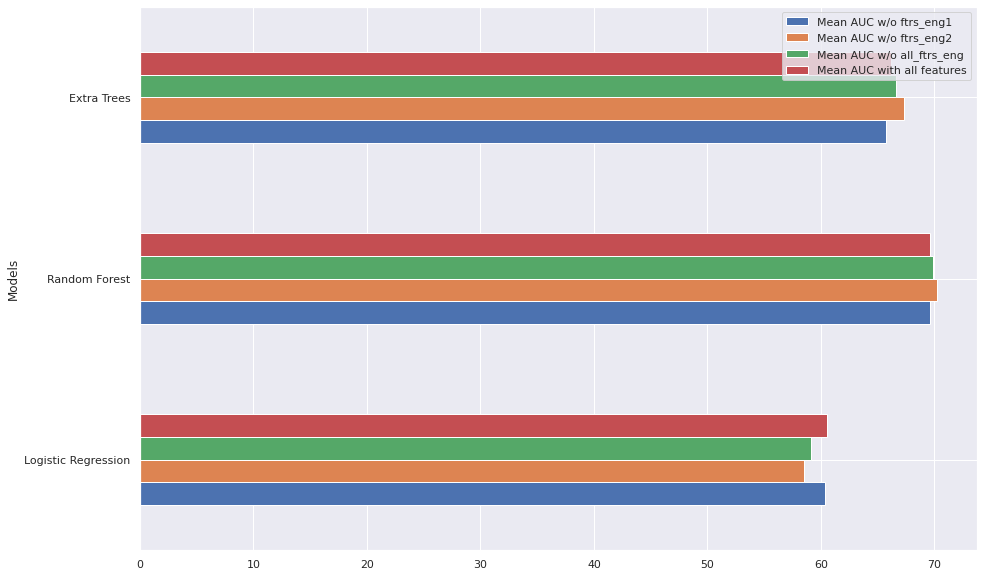

In [ ]:
res.plot.barh(x="Models", figsize=(15, 10))

#### Hyperparameter Tuning


Here we will find best parameters for our models using CV and hyperparameter tuning library `optuna`. 

We select 3 models from sklearn i.e. Logistic Regression, Random Forest and Extra Trees. 

LightGBM and XGBoost Models are also tuned for selecting best parameters.

In [ ]:
# # price feature engineering
# ftrs_eng1 = ['mean_price_p1', 'mean_price_p2', 'mean_price_p3']
# # date feature engineering
# ftrs_eng2 = ['ref_activ', 'ref_end', 'ref_renewal', 'ref_modif_prod']
# all_ftrs_eng = ftrs_eng1 + ftrs_eng2

# df = df.drop(ftrs_eng2, axis=1)

dropcols = ["churn", "id", "forecast_cons_year", "num_years_antig"]

Sklearn Models

In [ ]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
import optuna

def objective(trial):

    classifier_name = trial.suggest_categorical("classifier_name", ["LogReg", "RF", "ET"])
    
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = linear_model.LogisticRegression(C=logreg_c, class_weight='balanced')
    elif classifier_name == "RF":
        rf_crit = trial.suggest_categorical('rf_crit', ['gini', 'entropy'])
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 1, 150)
        rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 60)
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 1000)
        rf_max_depth = trial.suggest_int('rf_max_depth', 4, 50)
        rf_max_features = trial.suggest_uniform('rf_max_features', 0.15, 1.0)
        rf_max_samples = trial.suggest_uniform('rf_max_samples', 0.6, 0.99)
        classifier_obj = ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, class_weight='balanced',
            min_samples_leaf=rf_min_samples_leaf, min_samples_split=rf_min_samples_split,
            criterion=rf_crit, max_samples=rf_max_samples
        )
    else:
        et_crit = trial.suggest_categorical('et_crit', ['gini', 'entropy'])
        et_min_samples_split = trial.suggest_int('et_min_samples_split', 1, 150)
        et_min_samples_leaf = trial.suggest_int('et_min_samples_leaf', 1, 60)
        et_n_estimators = trial.suggest_int('et_n_estimators', 50, 1000)
        et_max_depth = trial.suggest_int('et_max_depth', 4, 50)
        et_max_samples = trial.suggest_uniform('et_max_samples', 0.6, 0.99)
        classifier_obj = ensemble.ExtraTreesClassifier(
            max_depth=et_max_depth, n_estimators=et_n_estimators, class_weight='balanced',
            min_samples_leaf=et_min_samples_leaf, min_samples_split=et_min_samples_split,
            criterion=et_crit, max_samples=et_max_samples
        )

    X, y = df.drop(dropcols, axis=1), df['churn'].values
    score = model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5, verbose=1, scoring='roc_auc')
    auc_score = score.mean()
    return auc_score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")

trial = study.best_trial
print("  Value: {}".format(trial.value))

print(" Best params:", study.best_params)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-08 13:37:32,465] A new study created in memory with name: no-name-79c066ef-cef1-449f-84de-b92d9d5da0af
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[I 2021-04-08 13:37:35,745] Trial 0 finished with value: 0.6032253402009774 and parameters: {'classifier_name': 'LogReg', 'logreg_c': 8.684247697492507}. Best is trial 0 with value: 0.6032253402009774.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[I 2021-04-08 13:37:37,669] Trial 1 finished with value: 0.5948404418934038 and parameters: {'classifier_name': 'LogReg', 'logreg_c': 64.93255340927774}. Best is trial 0 with value: 0.6032253402009774.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[I 2021-04-08 13:37:39,604] Trial 2 finis

Number of finished trials:  20
Best trial:
  Value: 0.700014119606064
 Best params: {'classifier_name': 'RF', 'rf_crit': 'gini', 'rf_min_samples_split': 72, 'rf_min_samples_leaf': 3, 'rf_n_estimators': 564, 'rf_max_depth': 13, 'rf_max_features': 0.9119661182336729, 'rf_max_samples': 0.619902005211731}
  Params: 
    classifier_name: RF
    rf_crit: gini
    rf_min_samples_split: 72
    rf_min_samples_leaf: 3
    rf_n_estimators: 564
    rf_max_depth: 13
    rf_max_features: 0.9119661182336729
    rf_max_samples: 0.619902005211731


In [ ]:
optuna.visualization.plot_optimization_history(study)

LightGBM

In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

def search_lgbm():
    dtrain = lgb.Dataset(df.drop(dropcols, axis=1), label=df['churn'].values)

    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        'is_unbalance' : 'true',
        "boosting_type": "gbdt",
    }

    tuner = lgb.LightGBMTunerCV(
        params, dtrain, verbose_eval=100, early_stopping_rounds=100, 
        folds=StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    )

    tuner.run()
    print("-"*80)
    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [141]:
search_lgbm()

[I 2021-04-08 13:46:08,150] A new study created in memory with name: no-name-7f0ec124-fc63-46dc-b85c-b585e5c1b38d
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.700123 + 0.0137813


feature_fraction, val_score: 0.704518:  14%|#4        | 1/7 [00:04<00:27,  4.60s/it]

[100]	cv_agg's auc: 0.692982 + 0.00772581


feature_fraction, val_score: 0.704518:  29%|##8       | 2/7 [00:09<00:23,  4.65s/it]

[100]	cv_agg's auc: 0.706118 + 0.0161009


feature_fraction, val_score: 0.707438:  43%|####2     | 3/7 [00:18<00:23,  5.84s/it]

[100]	cv_agg's auc: 0.70588 + 0.0119677


feature_fraction, val_score: 0.708706:  57%|#####7    | 4/7 [00:25<00:18,  6.26s/it]

[100]	cv_agg's auc: 0.705009 + 0.00599032


feature_fraction, val_score: 0.708706:  71%|#######1  | 5/7 [00:32<00:13,  6.66s/it]

[100]	cv_agg's auc: 0.706684 + 0.00922896


feature_fraction, val_score: 0.709602:  86%|########5 | 6/7 [00:39<00:06,  6.58s/it]

[100]	cv_agg's auc: 0.700819 + 0.00921272


num_leaves, val_score: 0.709602:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.70245 + 0.00780483
[200]	cv_agg's auc: 0.708022 + 0.00823786
[300]	cv_agg's auc: 0.712196 + 0.00573977
[400]	cv_agg's auc: 0.7149 + 0.0042209
[500]	cv_agg's auc: 0.71593 + 0.00329089


num_leaves, val_score: 0.716066:   5%|5         | 1/20 [01:02<19:45, 62.41s/it]

[100]	cv_agg's auc: 0.699395 + 0.00665061
[200]	cv_agg's auc: 0.70429 + 0.00580618
[300]	cv_agg's auc: 0.707777 + 0.00634249
[400]	cv_agg's auc: 0.711148 + 0.00664373
[500]	cv_agg's auc: 0.711874 + 0.00703514


num_leaves, val_score: 0.716066:  10%|#         | 2/20 [02:03<18:36, 62.03s/it]

[100]	cv_agg's auc: 0.71119 + 0.00715145
[200]	cv_agg's auc: 0.714389 + 0.0048387
[300]	cv_agg's auc: 0.712522 + 0.00485193


num_leaves, val_score: 0.716066:  15%|#5        | 3/20 [02:51<16:24, 57.93s/it]

[100]	cv_agg's auc: 0.698459 + 0.0151878


num_leaves, val_score: 0.716066:  20%|##        | 4/20 [02:56<11:12, 42.00s/it]

[100]	cv_agg's auc: 0.695086 + 0.0121567


num_leaves, val_score: 0.716066:  25%|##5       | 5/20 [03:07<08:10, 32.73s/it]

[100]	cv_agg's auc: 0.706955 + 0.00721485
[200]	cv_agg's auc: 0.708923 + 0.00724314


num_leaves, val_score: 0.716066:  30%|###       | 6/20 [03:38<07:30, 32.19s/it]

[100]	cv_agg's auc: 0.702212 + 0.0138193
[200]	cv_agg's auc: 0.703623 + 0.0134826


num_leaves, val_score: 0.716066:  35%|###5      | 7/20 [03:45<05:19, 24.58s/it]

[100]	cv_agg's auc: 0.705767 + 0.00779998
[200]	cv_agg's auc: 0.709115 + 0.0084682
[300]	cv_agg's auc: 0.711218 + 0.00636008
[400]	cv_agg's auc: 0.713188 + 0.00525962
[500]	cv_agg's auc: 0.715698 + 0.00321974
[600]	cv_agg's auc: 0.7159 + 0.0032245
[700]	cv_agg's auc: 0.715584 + 0.00331318


num_leaves, val_score: 0.716135:  40%|####      | 8/20 [04:56<07:41, 38.46s/it]

[100]	cv_agg's auc: 0.705312 + 0.0134287
[200]	cv_agg's auc: 0.706019 + 0.0133335
[300]	cv_agg's auc: 0.706085 + 0.00885422


num_leaves, val_score: 0.716135:  45%|####5     | 9/20 [05:20<06:15, 34.15s/it]

[100]	cv_agg's auc: 0.707609 + 0.00747755
[200]	cv_agg's auc: 0.709815 + 0.00668044
[300]	cv_agg's auc: 0.709953 + 0.00463436
[400]	cv_agg's auc: 0.710197 + 0.00459674


num_leaves, val_score: 0.716135:  50%|#####     | 10/20 [06:13<06:38, 39.82s/it]

[100]	cv_agg's auc: 0.702958 + 0.0133876


num_leaves, val_score: 0.716135:  55%|#####5    | 11/20 [06:31<05:00, 33.36s/it]

[100]	cv_agg's auc: 0.707375 + 0.00714261
[200]	cv_agg's auc: 0.709666 + 0.00416718
[300]	cv_agg's auc: 0.712597 + 0.0037088
[400]	cv_agg's auc: 0.71229 + 0.00497557


num_leaves, val_score: 0.716135:  60%|######    | 12/20 [07:19<05:01, 37.67s/it]

[100]	cv_agg's auc: 0.714672 + 0.00944625
[200]	cv_agg's auc: 0.716301 + 0.00772345
[300]	cv_agg's auc: 0.717827 + 0.00653498
[400]	cv_agg's auc: 0.719022 + 0.00377041


num_leaves, val_score: 0.719070:  65%|######5   | 13/20 [08:21<05:13, 44.81s/it]

[100]	cv_agg's auc: 0.71201 + 0.0060267
[200]	cv_agg's auc: 0.716742 + 0.00511281
[300]	cv_agg's auc: 0.718762 + 0.00338224
[400]	cv_agg's auc: 0.719195 + 0.00328308


num_leaves, val_score: 0.719794:  70%|#######   | 14/20 [09:20<04:54, 49.13s/it]

[100]	cv_agg's auc: 0.709174 + 0.00881907
[200]	cv_agg's auc: 0.712036 + 0.00566373
[300]	cv_agg's auc: 0.713663 + 0.00422655
[400]	cv_agg's auc: 0.715595 + 0.00452782


num_leaves, val_score: 0.719794:  75%|#######5  | 15/20 [10:21<04:23, 52.67s/it]

[100]	cv_agg's auc: 0.706668 + 0.00543443
[200]	cv_agg's auc: 0.710993 + 0.00379718
[300]	cv_agg's auc: 0.713103 + 0.00278538
[400]	cv_agg's auc: 0.714331 + 0.00372973
[500]	cv_agg's auc: 0.714535 + 0.00372872


num_leaves, val_score: 0.719794:  80%|########  | 16/20 [11:25<03:44, 56.17s/it]

[100]	cv_agg's auc: 0.711269 + 0.0034945
[200]	cv_agg's auc: 0.711709 + 0.00300307


num_leaves, val_score: 0.719794:  85%|########5 | 17/20 [12:06<02:34, 51.48s/it]

[100]	cv_agg's auc: 0.698572 + 0.0134939


num_leaves, val_score: 0.719794:  90%|######### | 18/20 [12:19<01:20, 40.11s/it]

[100]	cv_agg's auc: 0.705613 + 0.0121438
[200]	cv_agg's auc: 0.711422 + 0.00860431
[300]	cv_agg's auc: 0.71365 + 0.00525577
[400]	cv_agg's auc: 0.716093 + 0.00285273


num_leaves, val_score: 0.719794:  95%|#########5| 19/20 [13:17<00:45, 45.50s/it]

[100]	cv_agg's auc: 0.698463 + 0.00742652
[200]	cv_agg's auc: 0.703672 + 0.00772419
[300]	cv_agg's auc: 0.708045 + 0.0083944
[400]	cv_agg's auc: 0.709063 + 0.00700468
[500]	cv_agg's auc: 0.712172 + 0.0059148
[600]	cv_agg's auc: 0.713883 + 0.00447695


bagging, val_score: 0.719794:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.692637 + 0.00510773


bagging, val_score: 0.719794:  10%|#         | 1/10 [00:23<03:30, 23.41s/it]

[100]	cv_agg's auc: 0.707617 + 0.0128064
[200]	cv_agg's auc: 0.711571 + 0.0149529


bagging, val_score: 0.719794:  20%|##        | 2/10 [01:07<03:56, 29.51s/it]

[100]	cv_agg's auc: 0.71195 + 0.00859838
[200]	cv_agg's auc: 0.714176 + 0.00712893
[300]	cv_agg's auc: 0.714417 + 0.00749259
[400]	cv_agg's auc: 0.715234 + 0.00730399


bagging, val_score: 0.719794:  30%|###       | 3/10 [02:13<04:43, 40.46s/it]

[100]	cv_agg's auc: 0.692629 + 0.00676055
[200]	cv_agg's auc: 0.69653 + 0.00279541


bagging, val_score: 0.719794:  40%|####      | 4/10 [02:47<03:51, 38.51s/it]

[100]	cv_agg's auc: 0.70392 + 0.00986436
[200]	cv_agg's auc: 0.701484 + 0.00625769


bagging, val_score: 0.719794:  50%|#####     | 5/10 [03:31<03:21, 40.23s/it]

[100]	cv_agg's auc: 0.706874 + 0.00670958
[200]	cv_agg's auc: 0.7087 + 0.00847509
[300]	cv_agg's auc: 0.709701 + 0.00876884
[400]	cv_agg's auc: 0.711509 + 0.00727882
[500]	cv_agg's auc: 0.71176 + 0.00696811


bagging, val_score: 0.719794:  60%|######    | 6/10 [04:43<03:19, 49.75s/it]

[100]	cv_agg's auc: 0.713659 + 0.00912294
[200]	cv_agg's auc: 0.716321 + 0.00970334
[300]	cv_agg's auc: 0.718495 + 0.00724554
[400]	cv_agg's auc: 0.71813 + 0.00691499


bagging, val_score: 0.719794:  70%|#######   | 7/10 [05:49<02:43, 54.56s/it]

[100]	cv_agg's auc: 0.71669 + 0.0060754
[200]	cv_agg's auc: 0.719221 + 0.00506528
[300]	cv_agg's auc: 0.718885 + 0.00415123


bagging, val_score: 0.719794:  80%|########  | 8/10 [06:42<01:48, 54.34s/it]

[100]	cv_agg's auc: 0.691379 + 0.00764092
[200]	cv_agg's auc: 0.700344 + 0.0148127
[300]	cv_agg's auc: 0.674543 + 0.0694231


bagging, val_score: 0.719794:  90%|######### | 9/10 [07:20<00:49, 49.43s/it]

[100]	cv_agg's auc: 0.704026 + 0.00815276
[200]	cv_agg's auc: 0.707519 + 0.0054712
[300]	cv_agg's auc: 0.710189 + 0.00576212


feature_fraction_stage2, val_score: 0.719794:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.710926 + 0.00407893
[200]	cv_agg's auc: 0.714105 + 0.00391443
[300]	cv_agg's auc: 0.714659 + 0.00254783
[400]	cv_agg's auc: 0.715924 + 0.00333076


feature_fraction_stage2, val_score: 0.719794:  17%|#6        | 1/6 [00:56<04:42, 56.59s/it]

[100]	cv_agg's auc: 0.70894 + 0.00541005
[200]	cv_agg's auc: 0.710888 + 0.00413894
[300]	cv_agg's auc: 0.710899 + 0.00512921
[400]	cv_agg's auc: 0.712896 + 0.0045466


feature_fraction_stage2, val_score: 0.719794:  33%|###3      | 2/6 [01:55<03:49, 57.42s/it]

[100]	cv_agg's auc: 0.715017 + 0.0127748
[200]	cv_agg's auc: 0.714359 + 0.00659431


feature_fraction_stage2, val_score: 0.719794:  50%|#####     | 3/6 [02:34<02:35, 51.75s/it]

[100]	cv_agg's auc: 0.710815 + 0.0093055
[200]	cv_agg's auc: 0.712216 + 0.007928
[300]	cv_agg's auc: 0.71635 + 0.00609109
[400]	cv_agg's auc: 0.718176 + 0.00468263
[500]	cv_agg's auc: 0.717758 + 0.00434686


feature_fraction_stage2, val_score: 0.719794:  67%|######6   | 4/6 [03:42<01:53, 56.65s/it]

[100]	cv_agg's auc: 0.711697 + 0.00698046
[200]	cv_agg's auc: 0.714012 + 0.00541927
[300]	cv_agg's auc: 0.715812 + 0.00354287
[400]	cv_agg's auc: 0.716877 + 0.0030422


feature_fraction_stage2, val_score: 0.719794:  83%|########3 | 5/6 [04:44<00:58, 58.11s/it]

[100]	cv_agg's auc: 0.711276 + 0.00718351
[200]	cv_agg's auc: 0.712638 + 0.00532298
[300]	cv_agg's auc: 0.714881 + 0.00431387
[400]	cv_agg's auc: 0.71588 + 0.00431
[500]	cv_agg's auc: 0.716661 + 0.00485619


regularization_factors, val_score: 0.719794:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.710735 + 0.00630209
[200]	cv_agg's auc: 0.713423 + 0.00667696
[300]	cv_agg's auc: 0.717116 + 0.00416083
[400]	cv_agg's auc: 0.71695 + 0.00381984


regularization_factors, val_score: 0.719794:   5%|5         | 1/20 [00:56<17:48, 56.23s/it]

[100]	cv_agg's auc: 0.709805 + 0.00352248
[200]	cv_agg's auc: 0.717024 + 0.000867093
[300]	cv_agg's auc: 0.717923 + 0.00255225
[400]	cv_agg's auc: 0.717834 + 0.00311466


regularization_factors, val_score: 0.719794:  10%|#         | 2/20 [01:51<16:48, 56.04s/it]

[100]	cv_agg's auc: 0.714517 + 0.00230488
[200]	cv_agg's auc: 0.718928 + 0.00445129
[300]	cv_agg's auc: 0.71978 + 0.00518416
[400]	cv_agg's auc: 0.719544 + 0.00481932


regularization_factors, val_score: 0.719942:  15%|#5        | 3/20 [02:44<15:34, 54.99s/it]

[100]	cv_agg's auc: 0.709834 + 0.00565336
[200]	cv_agg's auc: 0.711203 + 0.00350194
[300]	cv_agg's auc: 0.71497 + 0.00257707


regularization_factors, val_score: 0.719942:  20%|##        | 4/20 [03:40<14:45, 55.35s/it]

[100]	cv_agg's auc: 0.708432 + 0.00478904
[200]	cv_agg's auc: 0.713405 + 0.00277799
[300]	cv_agg's auc: 0.715899 + 0.0026071


regularization_factors, val_score: 0.719942:  25%|##5       | 5/20 [04:33<13:41, 54.75s/it]

[100]	cv_agg's auc: 0.70778 + 0.00730456
[200]	cv_agg's auc: 0.712257 + 0.00643614
[300]	cv_agg's auc: 0.713921 + 0.00653482
[400]	cv_agg's auc: 0.713599 + 0.00681825


regularization_factors, val_score: 0.719942:  30%|###       | 6/20 [05:26<12:36, 54.07s/it]

[100]	cv_agg's auc: 0.708581 + 0.00318892
[200]	cv_agg's auc: 0.710084 + 0.00342958
[300]	cv_agg's auc: 0.709827 + 0.00418251


regularization_factors, val_score: 0.719942:  35%|###5      | 7/20 [05:54<09:59, 46.14s/it]

[100]	cv_agg's auc: 0.708546 + 0.0022792
[200]	cv_agg's auc: 0.71074 + 0.00381095
[300]	cv_agg's auc: 0.71575 + 0.00368234
[400]	cv_agg's auc: 0.715769 + 0.00254453


regularization_factors, val_score: 0.719942:  40%|####      | 8/20 [06:50<09:52, 49.37s/it]

[100]	cv_agg's auc: 0.712254 + 0.00692094
[200]	cv_agg's auc: 0.718142 + 0.00709347
[300]	cv_agg's auc: 0.718387 + 0.00638208


regularization_factors, val_score: 0.719942:  45%|####5     | 9/20 [07:34<08:44, 47.71s/it]

[100]	cv_agg's auc: 0.712984 + 0.00277587
[200]	cv_agg's auc: 0.716229 + 0.00489936
[300]	cv_agg's auc: 0.717342 + 0.00520465


regularization_factors, val_score: 0.719942:  50%|#####     | 10/20 [08:21<07:53, 47.33s/it]

[100]	cv_agg's auc: 0.712292 + 0.006305
[200]	cv_agg's auc: 0.716153 + 0.00523828
[300]	cv_agg's auc: 0.717994 + 0.0037275
[400]	cv_agg's auc: 0.719396 + 0.00365303
[500]	cv_agg's auc: 0.719895 + 0.00343699


regularization_factors, val_score: 0.719990:  55%|#####5    | 11/20 [09:27<07:58, 53.16s/it]

[100]	cv_agg's auc: 0.707681 + 0.00550285
[200]	cv_agg's auc: 0.714434 + 0.00697771
[300]	cv_agg's auc: 0.717865 + 0.00535131
[400]	cv_agg's auc: 0.718855 + 0.00439134


regularization_factors, val_score: 0.719990:  60%|######    | 12/20 [10:32<07:32, 56.53s/it]

[100]	cv_agg's auc: 0.712419 + 0.00289681
[200]	cv_agg's auc: 0.719896 + 0.00279273
[300]	cv_agg's auc: 0.720559 + 0.00232799


regularization_factors, val_score: 0.720913:  65%|######5   | 13/20 [11:27<06:33, 56.21s/it]

[100]	cv_agg's auc: 0.714562 + 0.00662202
[200]	cv_agg's auc: 0.716781 + 0.00253154
[300]	cv_agg's auc: 0.719022 + 0.00211957
[400]	cv_agg's auc: 0.720132 + 0.0030218


regularization_factors, val_score: 0.720913:  70%|#######   | 14/20 [12:31<05:50, 58.39s/it]

[100]	cv_agg's auc: 0.708561 + 0.00700862
[200]	cv_agg's auc: 0.710647 + 0.00562576
[300]	cv_agg's auc: 0.712447 + 0.00319113
[400]	cv_agg's auc: 0.714659 + 0.00316141
[500]	cv_agg's auc: 0.714652 + 0.00286283
[600]	cv_agg's auc: 0.714633 + 0.00292535


regularization_factors, val_score: 0.720913:  75%|#######5  | 15/20 [13:39<05:06, 61.25s/it]

[100]	cv_agg's auc: 0.710484 + 0.00598973
[200]	cv_agg's auc: 0.713889 + 0.00128155
[300]	cv_agg's auc: 0.717039 + 0.000385565
[400]	cv_agg's auc: 0.717588 + 0.00139621


regularization_factors, val_score: 0.720913:  80%|########  | 16/20 [14:42<04:07, 61.76s/it]

[100]	cv_agg's auc: 0.714938 + 0.00541123
[200]	cv_agg's auc: 0.717427 + 0.00311785
[300]	cv_agg's auc: 0.718604 + 0.000945095
[400]	cv_agg's auc: 0.719452 + 0.00114563
[500]	cv_agg's auc: 0.719424 + 0.00129512


regularization_factors, val_score: 0.720913:  85%|########5 | 17/20 [15:51<03:12, 64.04s/it]

[100]	cv_agg's auc: 0.711663 + 0.00650155
[200]	cv_agg's auc: 0.716816 + 0.00647995
[300]	cv_agg's auc: 0.718217 + 0.00560328
[400]	cv_agg's auc: 0.719221 + 0.00499755


regularization_factors, val_score: 0.720913:  90%|######### | 18/20 [16:52<02:06, 63.13s/it]

[100]	cv_agg's auc: 0.709723 + 0.00328951
[200]	cv_agg's auc: 0.715311 + 0.0027747
[300]	cv_agg's auc: 0.717173 + 0.00335304
[400]	cv_agg's auc: 0.717285 + 0.00429364


regularization_factors, val_score: 0.720913:  95%|#########5| 19/20 [17:57<01:03, 63.63s/it]

[100]	cv_agg's auc: 0.717313 + 0.00354714
[200]	cv_agg's auc: 0.71808 + 0.00397793


min_data_in_leaf, val_score: 0.720913:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.712012 + 0.00786326


min_data_in_leaf, val_score: 0.720913:  20%|##        | 1/5 [00:13<00:52, 13.03s/it]

[100]	cv_agg's auc: 0.711495 + 0.00815937
[200]	cv_agg's auc: 0.716191 + 0.00485079
[300]	cv_agg's auc: 0.716383 + 0.00338865


min_data_in_leaf, val_score: 0.720913:  40%|####      | 2/5 [01:01<01:10, 23.51s/it]

[100]	cv_agg's auc: 0.70485 + 0.0147628
[200]	cv_agg's auc: 0.712071 + 0.0064193
[300]	cv_agg's auc: 0.71725 + 0.00641084
[400]	cv_agg's auc: 0.719293 + 0.00671738
[500]	cv_agg's auc: 0.719834 + 0.00643878


min_data_in_leaf, val_score: 0.720913:  60%|######    | 3/5 [02:17<01:18, 39.33s/it]

[600]	cv_agg's auc: 0.719605 + 0.00639766
[100]	cv_agg's auc: 0.713779 + 0.0106331
[200]	cv_agg's auc: 0.717316 + 0.00802356
[300]	cv_agg's auc: 0.721078 + 0.00790328
[400]	cv_agg's auc: 0.722829 + 0.00774762
[500]	cv_agg's auc: 0.722413 + 0.00711788


min_data_in_leaf, val_score: 0.723026:  80%|########  | 4/5 [03:28<00:48, 48.86s/it]

[100]	cv_agg's auc: 0.711444 + 0.00622898
[200]	cv_agg's auc: 0.715628 + 0.00679869
[300]	cv_agg's auc: 0.716078 + 0.0077054


min_data_in_leaf, val_score: 0.723026: 100%|##########| 5/5 [04:02<00:00, 48.52s/it]

--------------------------------------------------------------------------------
Best score: 0.7230257445732596
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'is_unbalance': 'true', 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.3833140143014624e-06, 'lambda_l2': 0.0019055462737397018, 'num_leaves': 250, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    is_unbalance: true
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.3833140143014624e-06
    lambda_l2: 0.0019055462737397018
    num_leaves: 250
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


XGB

In [142]:
import xgboost as xgb
import optuna

# CV_RESULT_DIR = "./xgboost_cv_results"

def objective(trial):

    dtrain = xgb.DMatrix(df.drop(dropcols, axis=1), label=df['churn'].values)

    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "scale_pos_weight" : trial.suggest_int("scale_pos_weight", 5, 10)
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_cv_results = xgb.cv(params=param,
                            dtrain=dtrain,
                            num_boost_round=1000,
                            nfold=FOLDS,
                            stratified=True,
                            early_stopping_rounds=100,
                            seed=42,
                            verbose_eval=True,
                            )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # # Save cross-validation results.
    # filepath = os.path.join(CV_RESULT_DIR, "{}.csv".format(trial.number))
    # xgb_cv_results.to_csv(filepath, index=False)

    # Extract the best score.
    best_score = xgb_cv_results["test-auc-mean"].values[-1]
    return best_score

In [143]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")

trial = study.best_trial
print("  Value: {}".format(trial.value))

print("Best params:", study.best_params)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

[I 2021-04-08 14:37:53,043] A new study created in memory with name: no-name-1dfcab62-2360-49f0-bb95-55555331f71a


[0]	train-auc:0.640881+0.00249222	test-auc:0.633299+0.00865829
[1]	train-auc:0.646702+0.00262388	test-auc:0.63741+0.00893928
[2]	train-auc:0.64951+0.00266462	test-auc:0.638826+0.00919979
[3]	train-auc:0.65123+0.00262845	test-auc:0.639473+0.0095264
[4]	train-auc:0.652337+0.00259458	test-auc:0.63982+0.00972984
[5]	train-auc:0.653079+0.00255553	test-auc:0.63995+0.00985244
[6]	train-auc:0.653645+0.00254432	test-auc:0.640034+0.00992633
[7]	train-auc:0.654079+0.00252256	test-auc:0.640114+0.00992326
[8]	train-auc:0.654406+0.00250593	test-auc:0.64007+0.0099207
[9]	train-auc:0.654662+0.00249942	test-auc:0.640127+0.00990875
[10]	train-auc:0.654872+0.00249459	test-auc:0.640116+0.00988396
[11]	train-auc:0.655049+0.00249504	test-auc:0.640075+0.0098877
[12]	train-auc:0.655204+0.00249531	test-auc:0.640033+0.0098354
[13]	train-auc:0.655336+0.00250853	test-auc:0.640022+0.00981326
[14]	train-auc:0.655456+0.0025074	test-auc:0.639975+0.00981741
[15]	train-auc:0.655554+0.00250929	test-auc:0.639938+0.009800

[I 2021-04-08 14:38:03,113] Trial 0 finished with value: 0.6401273999999999 and parameters: {'booster': 'gblinear', 'lambda': 0.000326084803127974, 'alpha': 3.066627797225178e-06, 'scale_pos_weight': 6}. Best is trial 0 with value: 0.6401273999999999.


[0]	train-auc:0.621366+0.0608548	test-auc:0.638198+0.00907117
[1]	train-auc:0.627439+0.0639394	test-auc:0.642871+0.0107126
[2]	train-auc:0.659121+0.00642283	test-auc:0.640632+0.0112107
[3]	train-auc:0.662456+0.00355904	test-auc:0.648481+0.0114845
[4]	train-auc:0.660939+0.00393828	test-auc:0.649899+0.0135364
[5]	train-auc:0.663891+0.00700192	test-auc:0.653042+0.00955891
[6]	train-auc:0.668048+0.00531877	test-auc:0.650288+0.0135708
[7]	train-auc:0.66906+0.0037869	test-auc:0.655101+0.0124512
[8]	train-auc:0.669598+0.00416073	test-auc:0.657594+0.0117526
[9]	train-auc:0.671159+0.00449722	test-auc:0.657252+0.0135082
[10]	train-auc:0.674179+0.00332918	test-auc:0.661902+0.0134739
[11]	train-auc:0.673491+0.00285172	test-auc:0.661042+0.0121373
[12]	train-auc:0.674937+0.00390561	test-auc:0.661945+0.0108827
[13]	train-auc:0.675131+0.0023633	test-auc:0.662315+0.0107694
[14]	train-auc:0.677346+0.00149156	test-auc:0.663375+0.0147622
[15]	train-auc:0.676872+0.00167809	test-auc:0.663807+0.0104327
[16]	

[I 2021-04-08 14:52:19,672] Trial 1 finished with value: 0.6909746000000001 and parameters: {'booster': 'dart', 'lambda': 0.8016658931610819, 'alpha': 1.816761252026296e-08, 'scale_pos_weight': 8, 'max_depth': 3, 'eta': 0.02384629080682012, 'gamma': 0.9454568221319409, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2625272351344666, 'skip_drop': 8.244765160212863e-08}. Best is trial 1 with value: 0.6909746000000001.


Number of finished trials:  2
Best trial:
  Value: 0.6909746000000001
Best params: {'booster': 'dart', 'lambda': 0.8016658931610819, 'alpha': 1.816761252026296e-08, 'scale_pos_weight': 8, 'max_depth': 3, 'eta': 0.02384629080682012, 'gamma': 0.9454568221319409, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2625272351344666, 'skip_drop': 8.244765160212863e-08}
  Params: 
    booster: dart
    lambda: 0.8016658931610819
    alpha: 1.816761252026296e-08
    scale_pos_weight: 8
    max_depth: 3
    eta: 0.02384629080682012
    gamma: 0.9454568221319409
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 0.2625272351344666
    skip_drop: 8.244765160212863e-08
  Number of estimators: 527


In [144]:
optuna.visualization.plot_optimization_history(study)

#### Best Models

Retrain the best models from the tuned parameters. We will also do a complete training on whole dataset with train-val 90%-10% split.

For final model, we select RandomForest from sklearn models and pick best parameters from LightGBM and XGBoost Model tuning.

In [145]:
dropcols = ["churn", "id", "forecast_cons_year", "num_years_antig"]
## if kfold is present
# dropcols = ["churn", "id", "forecast_cons_year", "num_years_antig", "kfold"]

In [146]:
from sklearn import model_selection
from sklearn import metrics

FOLDS = 5
THRESH = 0.85

df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df['churn'].values

kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42)
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [147]:
from sklearn import ensemble

rf_parameters = {'criterion': 'gini', 'min_samples_split': 72, 'min_samples_leaf': 3, 
                 'class_weight': 'balanced', 'n_estimators': 564, 'max_depth': 13, 
                 'max_features': 0.9119661182336729, 'max_samples': 0.619902005211731}
 
def train_rf(df, FOLDS):
    mean_auc = []
    for fold in range(FOLDS):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        features = [f for f in df.columns if f not in ("churn", "id", "forecast_cons_year", "num_years_antig", "kfold")]
        x_train, y_train = df_train[features].values, df_train['churn']
        x_valid, y_valid = df_valid[features].values, df_valid['churn']
        rf = ensemble.RandomForestClassifier(**rf_parameters)
        model = rf.fit(x_train, y_train)
        valid_preds = model.predict_proba(x_valid)[:, 1]

        print("-"*80)
        auc = metrics.roc_auc_score(y_valid, valid_preds, average='macro')
        print(f"Fold = {fold}, AUC = {auc}")
        print(metrics.classification_report(y_valid, (model.predict(x_valid) > THRESH).astype(int)))
        print("-"*80)
        mean_auc.append(auc)
    print("Model: Random Forest", "Mean AUC:", np.array(mean_auc).mean())

In [148]:
train_rf(df, FOLDS)

--------------------------------------------------------------------------------
Fold = 0, AUC = 0.6915267570689602
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2901
           1       0.29      0.26      0.27       319

    accuracy                           0.86      3220
   macro avg       0.61      0.59      0.60      3220
weighted avg       0.86      0.86      0.86      3220

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fold = 1, AUC = 0.7189525456707383
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2900
           1       0.33      0.31      0.32       319

    accuracy                           0.87      3219
   macro avg       0.63      0.62      0.62      3219
weighted avg       0.87      0.87      0.87      3219

---------------------------------

In [149]:
from sklearn import metrics
import lightgbm as lgb

# scale_pos_weights: 9 instead of is_unbalance: true
lgb_parameters = {'objective': 'binary', 'metric': 'auc', 'verbosity': -1,
                  'is_unbalance': 'true', 'boosting_type': 'gbdt', 'feature_pre_filter': False,
                  'lambda_l1': 1.3833140143014624e-06, 'lambda_l2': 0.0019055462737397018, 'num_leaves': 250, 
                  'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}
   
def train_lgbm(df, FOLDS):
    mean_auc = []
    for fold in range(FOLDS):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        features = [f for f in df.columns if f not in ("churn", "id", "forecast_cons_year", "num_years_antig", "kfold")]
        x_train = df_train[features].values
        x_valid = df_valid[features].values
        lgb_train = lgb.Dataset(x_train, df_train['churn'])
        lgb_val  = lgb.Dataset(x_valid, df_valid['churn'])

        model = lgb.train(lgb_parameters,
                          lgb_train,
                          valid_sets=lgb_val,
                          num_boost_round=1000,
                          early_stopping_rounds=100
                          )
        
        valid_preds = model.predict(x_valid)

        print("-"*80)
        auc = metrics.roc_auc_score(df_valid['churn'].values, valid_preds, average='macro')
        print(f"Fold = {fold}, AUC = {auc}")
        print(metrics.classification_report(df_valid['churn'].values, (model.predict(x_valid) > THRESH).astype(int)))
        print("-"*80)
        mean_auc.append(auc)
    print("Model: LightGBM", "Mean AUC:", np.array(mean_auc).mean())

In [150]:
train_lgbm(df, FOLDS)

[1]	valid_0's auc: 0.603781
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.62016
[3]	valid_0's auc: 0.631137
[4]	valid_0's auc: 0.638456
[5]	valid_0's auc: 0.65264
[6]	valid_0's auc: 0.65086
[7]	valid_0's auc: 0.657598
[8]	valid_0's auc: 0.659
[9]	valid_0's auc: 0.658188
[10]	valid_0's auc: 0.658427
[11]	valid_0's auc: 0.663047
[12]	valid_0's auc: 0.662792
[13]	valid_0's auc: 0.664652
[14]	valid_0's auc: 0.663223
[15]	valid_0's auc: 0.66669
[16]	valid_0's auc: 0.66764
[17]	valid_0's auc: 0.667526
[18]	valid_0's auc: 0.670504
[19]	valid_0's auc: 0.670761
[20]	valid_0's auc: 0.669183
[21]	valid_0's auc: 0.669396
[22]	valid_0's auc: 0.670675
[23]	valid_0's auc: 0.671787
[24]	valid_0's auc: 0.670998
[25]	valid_0's auc: 0.668611
[26]	valid_0's auc: 0.670184
[27]	valid_0's auc: 0.671905
[28]	valid_0's auc: 0.672031
[29]	valid_0's auc: 0.671661
[30]	valid_0's auc: 0.673213
[31]	valid_0's auc: 0.674536
[32]	valid_0's auc: 0.676847
[33]	valid_0's auc: 0.6773

In [167]:
from sklearn import metrics
import xgboost as xgb

xgb_parameters = {'objective': 'binary:logistic', 'eval_metric': 'auc',
                  'booster': 'dart', 'lambda': 0.8016658931610819, 'alpha': 1.816761252026296e-08,
                  'scale_pos_weight': 9, 'max_depth': 3, 'eta': 0.02384629080682012, 'gamma': 0.9454568221319409,
                  'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest',
                  'rate_drop': 0.2625272351344666, 'skip_drop': 8.244765160212863e-08}

def train_xgbm(df, FOLDS):
    mean_auc = []
    for fold in range(FOLDS):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        features = [f for f in df.columns if f not in ("churn", "id", "forecast_cons_year", "num_years_antig", "kfold")]
        x_train = df_train[features]
        x_valid = df_valid[features]
        xgb_train = xgb.DMatrix(x_train, df_train['churn'])
        xgb_val  = xgb.DMatrix(x_valid, df_valid['churn'])

        model = xgb.train(xgb_parameters,
                          dtrain=xgb_train,
                          num_boost_round=1000,
                          evals=[(xgb_train, 'train'), (xgb_val, 'val')],
                          early_stopping_rounds=100,
                          verbose_eval=True,
                          )
        
        valid_preds = model.predict(xgb_val)
        print("-"*80)
        auc = metrics.roc_auc_score(df_valid['churn'].values, valid_preds, average='macro')
        print(f"Fold = {fold}, AUC = {auc}")
        print(metrics.classification_report(df_valid['churn'].values, (model.predict(xgb_val) > THRESH).astype(int)))
        print("-"*80)
        mean_auc.append(auc)
    print("Model: XGBM", "Mean AUC:", np.array(mean_auc).mean())

In [152]:
train_xgbm(df, FOLDS)

[0]	train-auc:0.657586	val-auc:0.641541
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[1]	train-auc:0.657586	val-auc:0.641541
[2]	train-auc:0.657586	val-auc:0.641541
[3]	train-auc:0.657586	val-auc:0.641541
[4]	train-auc:0.657586	val-auc:0.641541
[5]	train-auc:0.657586	val-auc:0.641541
[6]	train-auc:0.657586	val-auc:0.641541
[7]	train-auc:0.657586	val-auc:0.641541
[8]	train-auc:0.657586	val-auc:0.641541
[9]	train-auc:0.65758	val-auc:0.641969
[10]	train-auc:0.65758	val-auc:0.641541
[11]	train-auc:0.657586	val-auc:0.641541
[12]	train-auc:0.657577	val-auc:0.641982
[13]	train-auc:0.657577	val-auc:0.645626
[14]	train-auc:0.661059	val-auc:0.6454
[15]	train-auc:0.661059	val-auc:0.645407
[16]	train-auc:0.661058	val-auc:0.645454
[17]	train-auc:0.663861	val-auc:0.647959
[18]	train-auc:0.670072	val-auc:0.652486
[19]	train-auc:0.669958	val-auc:0.652736
[20]	train-auc:0.67171	val-auc:0.648125
[21]	train-auc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[1]	train-auc:0.652764	val-auc:0.642372
[2]	train-auc:0.659034	val-auc:0.653086
[3]	train-auc:0.661946	val-auc:0.656846
[4]	train-auc:0.6652	val-auc:0.642086
[5]	train-auc:0.663971	val-auc:0.655144
[6]	train-auc:0.665354	val-auc:0.657067
[7]	train-auc:0.665953	val-auc:0.658202
[8]	train-auc:0.665051	val-auc:0.658869
[9]	train-auc:0.666656	val-auc:0.659241
[10]	train-auc:0.667296	val-auc:0.657775
[11]	train-auc:0.665803	val-auc:0.656713
[12]	train-auc:0.666881	val-auc:0.657427
[13]	train-auc:0.666809	val-auc:0.657496
[14]	train-auc:0.667227	val-auc:0.659306
[15]	train-auc:0.667229	val-auc:0.657697
[16]	train-auc:0.66727	val-auc:0.658203
[17]	train-auc:0.673268	val-auc:0.660791
[18]	train-auc:0.675761	val-auc:0.662311
[19]	train-auc:0.677314	val-auc:0.664577
[20]	train-auc:0.679865	val-auc:0.661197
[21]	train-auc:0.677465	val-auc:0.661437
[22]	train-auc:0.677165	val-auc:0.668855
[23]	train-auc:0.681302	val-auc:0.669823
[24]	train-auc:0.678395	val-auc:0.669309
[25]	train-auc:0.683299	val-

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[1]	train-auc:0.660642	val-auc:0.619072
[2]	train-auc:0.666349	val-auc:0.629127
[3]	train-auc:0.662007	val-auc:0.630358
[4]	train-auc:0.665688	val-auc:0.626376
[5]	train-auc:0.666268	val-auc:0.620943
[6]	train-auc:0.675939	val-auc:0.635763
[7]	train-auc:0.676066	val-auc:0.633749
[8]	train-auc:0.67606	val-auc:0.638844
[9]	train-auc:0.678212	val-auc:0.638021
[10]	train-auc:0.679615	val-auc:0.637377
[11]	train-auc:0.675913	val-auc:0.628376
[12]	train-auc:0.6738	val-auc:0.635068
[13]	train-auc:0.677289	val-auc:0.642654
[14]	train-auc:0.680229	val-auc:0.643473
[15]	train-auc:0.678089	val-auc:0.641701
[16]	train-auc:0.681281	val-auc:0.642708
[17]	train-auc:0.682411	val-auc:0.64503
[18]	train-auc:0.681494	val-auc:0.646411
[19]	train-auc:0.683872	val-auc:0.649468
[20]	train-auc:0.683151	val-auc:0.641952
[21]	train-auc:0.683144	val-auc:0.644729
[22]	train-auc:0.684851	val-auc:0.648474
[23]	train-auc:0.684092	val-auc:0.649839
[24]	train-auc:0.68451	val-auc:0.649236
[25]	train-auc:0.684119	val-au

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Will train until val-auc hasn't improved in 100 rounds.
[1]	train-auc:0.659464	val-auc:0.662762
[2]	train-auc:0.659176	val-auc:0.65404
[3]	train-auc:0.663254	val-auc:0.663546
[4]	train-auc:0.660556	val-auc:0.64462
[5]	train-auc:0.661181	val-auc:0.664127
[6]	train-auc:0.65977	val-auc:0.662882
[7]	train-auc:0.674645	val-auc:0.66896
[8]	train-auc:0.663421	val-auc:0.670245
[9]	train-auc:0.674755	val-auc:0.668801
[10]	train-auc:0.675723	val-auc:0.673619
[11]	train-auc:0.674214	val-auc:0.67154
[12]	train-auc:0.676361	val-auc:0.668392
[13]	train-auc:0.67525	val-auc:0.674848
[14]	train-auc:0.677515	val-auc:0.67859
[15]	train-auc:0.679034	val-auc:0.676473
[16]	train-auc:0.679322	val-auc:0.676528
[17]	train-auc:0.679186	val-auc:0.676493
[18]	train-auc:0.679235	val-auc:0.677961
[19]	train-auc:0.680443	val-auc:0.679965
[20]	train-auc:0.682125	val-auc:0.677409
[21]	train-auc:0.684061	val-auc:0.680052
[22]	train-auc:0.683613	val-auc:0.678578
[23]	train-auc:0.683846	val-auc:0.677772
[24]	train-auc:0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[1]	train-auc:0.656291	val-auc:0.616376
[2]	train-auc:0.677341	val-auc:0.633467
[3]	train-auc:0.656291	val-auc:0.634334
[4]	train-auc:0.676263	val-auc:0.616376
[5]	train-auc:0.677144	val-auc:0.616376
[6]	train-auc:0.678339	val-auc:0.634216
[7]	train-auc:0.677345	val-auc:0.628748
[8]	train-auc:0.676263	val-auc:0.634569
[9]	train-auc:0.678507	val-auc:0.635178
[10]	train-auc:0.676783	val-auc:0.629359
[11]	train-auc:0.676263	val-auc:0.616376
[12]	train-auc:0.677456	val-auc:0.634802
[13]	train-auc:0.67737	val-auc:0.635245
[14]	train-auc:0.67924	val-auc:0.63479
[15]	train-auc:0.677575	val-auc:0.635128
[16]	train-auc:0.680926	val-auc:0.634932
[17]	train-auc:0.680462	val-auc:0.634511
[18]	train-auc:0.681211	val-auc:0.633066
[19]	train-auc:0.682641	val-auc:0.630663
[20]	train-auc:0.682518	val-auc:0.63461
[21]	train-auc:0.682905	val-auc:0.632987
[22]	train-auc:0.682204	val-auc:0.634141
[23]	train-auc:0.682803	val-auc:0.637761
[24]	train-auc:0.683788	val-auc:0.635588
[25]	train-auc:0.684071	val-a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### Feature Importance


We will use `SHAP` library to visualize feature importances.

- The most agreed features by all the 3 models that are useful indicator are `margin_gross_pow_ele`, `margin_net_pow_ele`, `net_margin`, `cons_12m` and `date_endDayofYear`.
- Different `channel sales` and `tenure` are moderately useful features.

In [154]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import ensemble
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

THRESH = 0.85
dropcols = ["churn", "id", "forecast_cons_year", "num_years_antig", "kfold"]

In [155]:
X, y = df.drop(dropcols, axis=1), df['churn'].values
train_x, val_x, train_y, val_y = train_test_split(X, y,
                                                  stratify=y,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  shuffle=True)
print("Training shape:", train_x.shape, train_y.shape)
print("Validation shape:", val_x.shape, val_y.shape)

Training shape: (14486, 91) (14486,)
Validation shape: (1610, 91) (1610,)


In [156]:
def plot_cm(true, preds):
    """Plot confusion matrix"""
    plt.figure()
    cm = metrics.confusion_matrix(true, preds)
    labels = ['Retention', 'Churn']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

--------------------------------------------------------------------------------
Random Forest AUC = 0.712543103448276
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1450
           1       0.32      0.26      0.29       160

    accuracy                           0.87      1610
   macro avg       0.62      0.60      0.61      1610
weighted avg       0.86      0.87      0.87      1610

--------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

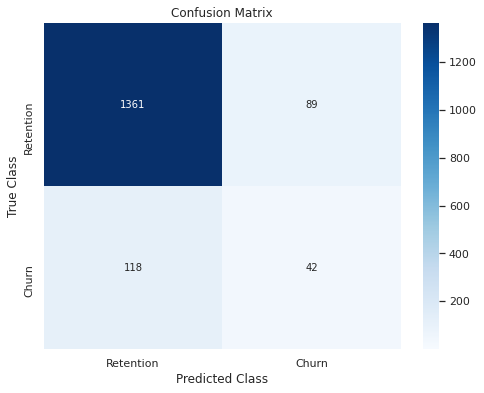

In [157]:
rf = ensemble.RandomForestClassifier(**rf_parameters)
rf.fit(train_x, train_y)
valid_preds = rf.predict_proba(val_x)[:, 1]

print("-"*80)
auc = metrics.roc_auc_score(val_y, valid_preds, average='macro')
print(f"Random Forest AUC = {auc}")
print(metrics.classification_report(val_y, (rf.predict(val_x) > THRESH).astype(int)))
print("-"*80)
plot_cm(val_y, (rf.predict(val_x) > THRESH).astype(int))

[1]	valid_0's auc: 0.627228
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.661043
[3]	valid_0's auc: 0.659343
[4]	valid_0's auc: 0.673334
[5]	valid_0's auc: 0.684276
[6]	valid_0's auc: 0.691455
[7]	valid_0's auc: 0.700347
[8]	valid_0's auc: 0.703446
[9]	valid_0's auc: 0.702694
[10]	valid_0's auc: 0.703909
[11]	valid_0's auc: 0.709802
[12]	valid_0's auc: 0.710862
[13]	valid_0's auc: 0.711164
[14]	valid_0's auc: 0.713726
[15]	valid_0's auc: 0.714356
[16]	valid_0's auc: 0.715401
[17]	valid_0's auc: 0.717272
[18]	valid_0's auc: 0.717948
[19]	valid_0's auc: 0.718582
[20]	valid_0's auc: 0.717638
[21]	valid_0's auc: 0.719073
[22]	valid_0's auc: 0.721509
[23]	valid_0's auc: 0.722091
[24]	valid_0's auc: 0.72006
[25]	valid_0's auc: 0.720578
[26]	valid_0's auc: 0.720392
[27]	valid_0's auc: 0.718823
[28]	valid_0's auc: 0.716276
[29]	valid_0's auc: 0.714534
[30]	valid_0's auc: 0.714034
[31]	valid_0's auc: 0.714026
[32]	valid_0's auc: 0.713401
[33]	valid_0's auc:

<Figure size 432x288 with 0 Axes>

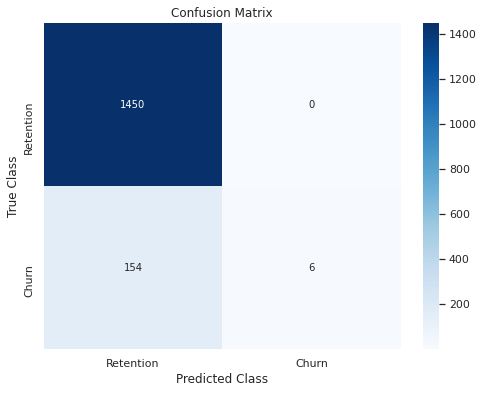

In [158]:
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(val_x, label=val_y)

lgbm = lgb.train(lgb_parameters,
                 lgb_train,
                 valid_sets=lgb_val,
                 num_boost_round=1000,
                 early_stopping_rounds=100
                 )

valid_preds = lgbm.predict(val_x)

print("-"*80)
auc = metrics.roc_auc_score(val_y, valid_preds, average='macro')
print(f"Lightgbm AUC = {auc}")
print(metrics.classification_report(val_y, (lgbm.predict(val_x) > THRESH).astype(int)))
print("-"*80)
plot_cm(val_y, (lgbm.predict(val_x) > THRESH).astype(int))

[0]	train-auc:0.65504	val-auc:0.635026
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[1]	train-auc:0.65504	val-auc:0.635026
[2]	train-auc:0.65504	val-auc:0.635026
[3]	train-auc:0.66892	val-auc:0.646713
[4]	train-auc:0.666042	val-auc:0.638151
[5]	train-auc:0.665854	val-auc:0.646748
[6]	train-auc:0.66635	val-auc:0.646935
[7]	train-auc:0.666339	val-auc:0.646849
[8]	train-auc:0.666365	val-auc:0.646849
[9]	train-auc:0.667316	val-auc:0.648787
[10]	train-auc:0.667412	val-auc:0.646849
[11]	train-auc:0.666673	val-auc:0.646782
[12]	train-auc:0.667949	val-auc:0.648853
[13]	train-auc:0.667955	val-auc:0.653763
[14]	train-auc:0.675805	val-auc:0.655246
[15]	train-auc:0.673065	val-auc:0.654341
[16]	train-auc:0.678299	val-auc:0.657744
[17]	train-auc:0.676248	val-auc:0.659088
[18]	train-auc:0.679462	val-auc:0.659603
[19]	train-auc:0.6805	val-auc:0.664756
[20]	train-auc:0.681235	val-auc:0.656547
[21]	train-auc:0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Figure size 432x288 with 0 Axes>

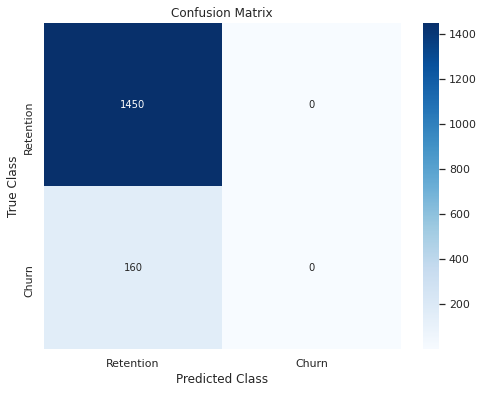

In [168]:
xgb_train = xgb.DMatrix(train_x, label=train_y)
xgb_val = xgb.DMatrix(val_x, label=val_y)

xgbm = xgb.train(xgb_parameters,
                 dtrain=xgb_train,
                 num_boost_round=1000,
                 evals=[(xgb_train, 'train'), (xgb_val, 'val')],
                 early_stopping_rounds=100,
                 verbose_eval=True,
                 )

valid_preds = xgbm.predict(xgb_val)

print("-"*80)
auc = metrics.roc_auc_score(val_y, valid_preds, average='macro')
print(f"XGBM AUC = {auc}")
print(metrics.classification_report(val_y, (xgbm.predict(xgb_val) > THRESH).astype(int)))
print("-"*80)
plot_cm(val_y, (xgbm.predict(xgb_val) > THRESH).astype(int))

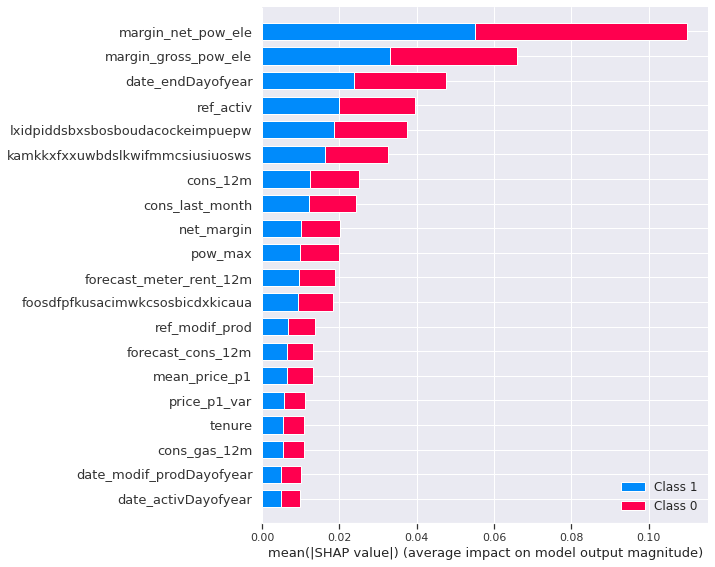

CPU times: user 1min 5s, sys: 323 ms, total: 1min 5s
Wall time: 1min 5s


In [160]:
%%time
import shap

shap_values = shap.TreeExplainer(rf).shap_values(val_x)
shap.summary_plot(shap_values, val_x)

/usr/local/lib/python3.7/dist-packages/shap/explainers/_tree.py:349: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



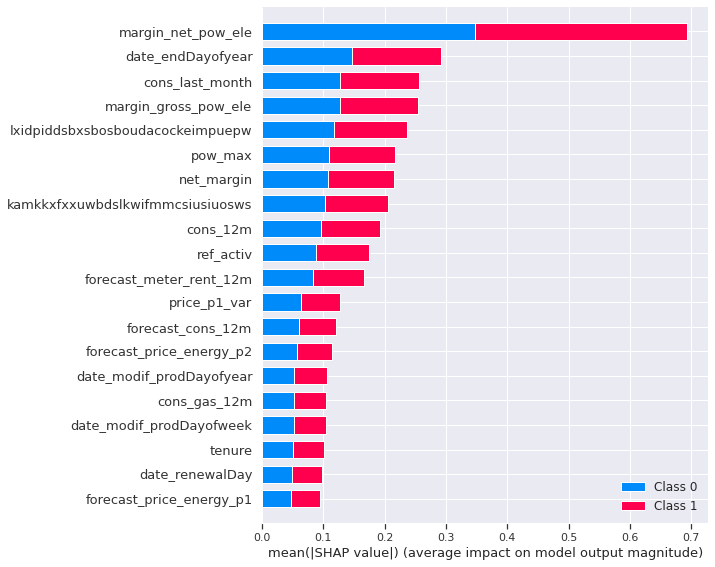

CPU times: user 14.5 s, sys: 141 ms, total: 14.7 s
Wall time: 7.84 s


In [161]:
%%time
import shap

shap_values = shap.TreeExplainer(lgbm).shap_values(val_x)
shap.summary_plot(shap_values, val_x)

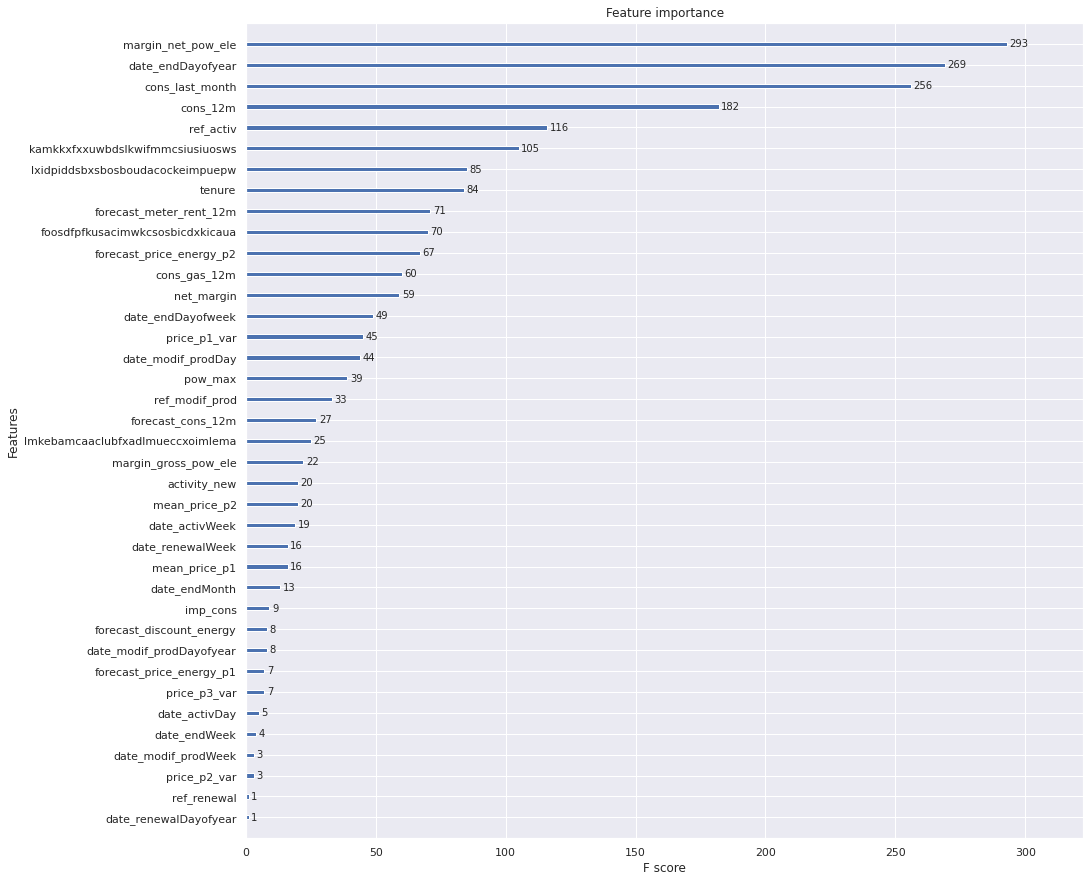

In [162]:
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(xgbm)

### Conclusion

We use ROC-AUC metric to monitor and compare different best models. From final 3 best model on same validation dataset,
- Random Forest : 72.60
- LightGBM : 74.65
- XGBoost Model : 70.48

We also monitor different metrics for `churn` class. The statistics for 3 models are

| Models  | Precision   |  Recall | F1-score   | Overall F1-score   |
|:---:|:---:|:---:|:---:|:---:|
| Random Forest   | 0.27  | 0.43  | 0.33  | 0.83  |
| LightGBM  |  0.87 | 0.12  |  0.22 |  0.91 |
| XGBoost Model  |  0.89 | 0.11  | 0.19  | 0.91  |

Of the 1610 validation samples, 1450 belongs to class 0 and 160 belongs to class 1 where class 0 = retention and class 1 = churn.

Here we consider Retention to be positive class and Churn to be negative class.

| Models  | TP  |  FN | FP | TN   |
|:---:|:---:|:---:|:---:|:---:|
| Random Forest   | 1266  | 184  | 91  | 69  |
| LightGBM  |  1447 | 3  | 143  | 17  |
| XGBoost Model  |  1448 |  2 | 143  |  17 |

---

**Insights**

- Even though RF has most number of churn prediction, it also have equally high amount of FN and FP.
- LightGBM and XGB on other hand have low number of churn prediction, but those predictions are accurate and also have very low FN (meaning retention users are predicted as belonging churn class). These have high values of FP (meaning churn users are misclassified as belonging retention). 
- This point of having low FN is important for our business use-case. Though our model makes mistake in not identifying all churn users i.e. it has FP, it identifies whatevers churn predictions with almost exactly i.e. 17/19=90% accuracy. 
- So if we use our model and if our model predicts that this user will most likely churn, it will be very accurate. This way we can even go out of way and offer >20% discount with this accurate model.
- But keep in mind that we are also missing almost 143/160 i.e. 90% churn users and only able to find 10% of churn user correctly.

**Bottomline: Even though our models don't have good recall in predicting churn users, the predicted churn users are precise. If we give discounts based on our current model, it will defintely go to churn users almost always (90% for current val set) but if we ask how many churn users model covers(recall) answer would be 10%(for current val set).**

---

**Future Work**

- More work on exploration of data (Using dates).
- Does using cyclical date variables help?
- Always having more data helps.
- Will PCA adding help?
- Look into different ways of handling outliers.
- We need to look into different ways to increase the recall of churn class using deep learning based methods (data hungry models).

#### Discount Strategy

Here we will analyse how effective our hypothesis is on validation dataset from above:

**Hypothesis: The SME division head proposed that we give a 20% discount to high propensity-to-churn customers.**



In [163]:
sub_df = val_x.copy()
sub_df['churn'] = val_y
# store probabilities for churning using 3 prediction models
sub_df['pred_xgb_churn'] = xgbm.predict(xgb_val)
sub_df['pred_lgb_churn'] = lgbm.predict(val_x)
sub_df['pred_rf_churn'] = rf.predict_proba(val_x)[:, 1]
sub_df.head()

,activity_new,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,tenure,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,mean_price_p1,mean_price_p2,mean_price_p3,ref_activ,ref_end,ref_renewal,ref_modif_prod,date_activYear,date_activMonth,date_activWeek,date_activDay,date_activDayofweek,date_activDayofyear,date_activIs_month_end,date_activIs_month_start,date_activIs_quarter_end,date_activIs_quarter_start,...,date_modif_prodMonth,date_modif_prodWeek,date_modif_prodDay,date_modif_prodDayofweek,date_modif_prodDayofyear,date_modif_prodIs_month_end,date_modif_prodIs_month_start,date_modif_prodIs_quarter_end,date_modif_prodIs_quarter_start,date_modif_prodIs_year_end,date_modif_prodIs_year_start,date_renewalYear,date_renewalMonth,date_renewalWeek,date_renewalDay,date_renewalDayofweek,date_renewalDayofyear,date_renewalIs_month_end,date_renewalIs_month_start,date_renewalIs_quarter_end,date_renewalIs_quarter_start,date_renewalIs_year_end,date_renewalIs_year_start,ewxeelcelemmiwuafmddpobolfuxioce,kamkkxfxxuwbdslkwifmmcsiusiuosws,ldkssxwpmemidmecebumciepifcamkci,lxidpiddsbxsbosboudacockeimpuepw,usapbepcfoloekilkwsdiboslwaxobdp,epumfxlbckeskwekxbiuasklxalciiuu,ewpakwlliwisiwduibdlfmalxowmwpci,fixdbufsefwooaasfcxdxadsiekoceaa,foosdfpfkusacimwkcsosbicdxkicaua,lmkebamcaaclubfxadlmueccxoimlema,sddiedcslfslkckwlfkdpoeeailfpeds,usilxuppasemubllopkaafesmlibmsdf,t,churn,pred_xgb_churn,pred_lgb_churn,pred_rf_churn
984,0,3.959185,0.0,0.000000,2.222742,0.0,1.140508,0.059075,0.000000,1.656207,0.000000,0.130804,0.146929,1,-0.530934,-0.309917,3,0.060943,0.000000,0.000000,1.656775,0.000000,0.000000,1.658215,0.000000,0.000000,-1.338170,0.654108,0.544427,-0.122228,2013,5,18,2,3,122,0,0,0,0,...,5,18,2,3,122,0,0,0,0,0,0,2015,5,18,3,6,123,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.508123,0.074980,0.333488
9983,0,0.000000,0.0,0.000000,3.416229,26.0,0.000000,0.083029,0.044315,1.670310,2.229323,0.091548,0.113602,2,-0.359071,-0.309917,7,0.084896,0.044604,0.000000,1.670310,0.000000,0.000000,1.672308,0.044604,0.000000,0.798540,-0.997253,-1.029546,-1.069668,2009,9,39,21,0,264,0,0,0,0,...,9,38,20,6,263,0,0,0,0,0,0,2015,11,46,12,3,316,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.367413,0.128658,0.309746
14995,0,4.191786,0.0,2.540329,2.621135,0.0,2.141481,0.048018,0.041618,1.619163,1.536558,0.371406,0.351192,1,-0.446339,-0.154014,5,0.051248,0.043306,0.031709,1.619730,1.404776,1.237152,1.621033,1.406565,1.239053,-0.195278,0.654108,0.544427,0.629190,2011,5,19,9,0,129,0,0,0,0,...,5,19,9,0,129,0,0,0,0,0,0,2015,5,20,17,6,137,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.470690,0.117844,0.291895
3049,80,4.147460,0.0,3.128399,2.931478,0.0,1.288249,0.059316,0.000000,1.670310,1.915822,-0.027908,0.012187,1,-0.372029,-0.372205,7,0.060680,0.000000,0.000000,1.658456,0.000000,0.000000,1.659883,0.000000,0.000000,0.748849,-0.722026,-0.767217,1.249927,2009,10,43,21,2,294,0,0,0,0,...,10,43,21,2,294,0,0,0,0,0,0,2015,10,43,23,4,296,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.412002,0.119461,0.237123
5140,0,3.814181,0.0,0.000000,2.605230,0.0,1.206556,0.058768,0.000000,1.656207,0.000000,-0.529373,-0.413540,1,-0.472882,-0.340051,7,0.060236,0.000000,0.000000,1.656091,0.000000,0.000000,1.657515,0.000000,0.000000,0.798540,-0.722026,-0.767217,1.282597,2009,10,40,1,3,274,0,1,0,1,...,10,40,1,3,274,0,1,0,1,0,0,2015,10,40,4,6,277,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.362697,0.050732,0.196469


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pred_col = 'pred_lgb_churn'
THERSH = 0.85

Baseline revenue

Electricity revenue for each customer consists of **energy consumption (amount * price) and the meter rent**

In [184]:
## using bcg solution as guideline
sub_df['revenue_baseline'] = (np.power(10, sub_df['forecast_cons_12m']) + 1) \
                             * (np.power(10, sub_df['forecast_price_energy_p1']) + 1) \
                             + (np.power(10, sub_df['forecast_meter_rent_12m']) + 1)

Churn revenue

Taking churn predictions into account. The dates start from 01-Jan to 01-March. Given that there are 59 days in between, and customers can leave in any of those 59 days, starting from 100% retention, there is 83.9% probability of churn. We take average of 100% and 83.9% i.e. 91.9% in account to weigh with the corresponding churn probabilities.

On subtracting from above baseline_revenue the churn weighting, we get the revenue after churn predictions.

In [185]:
sub_df['revenue_baseline_after_churn'] = sub_df['revenue_baseline'] * (1 - 0.919 * sub_df[pred_col])

When our model predicts the customers that are likely to churn, we offer in this case 20% discount. There are 3 likely scenarios when customer is offered a discount

- all customers who are offered a discount take it.
- Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability=0), and therefore the retained revenue is `0.8* basecase_revenue`, being `(1-discount_fraction)*basecase_revenue`. 
- Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually churned or not).



In [186]:
def get_rev_delta(df: pd.DataFrame, THRESH: float=0.5, 
                 discount_factor: float=0.2, pred_col: str='pred_xgb_churn') -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= THRESH
    """
    df['discount_revenue'] = df['revenue_baseline_after_churn']
    # handle case 2 of scenario
    df.loc[df[pred_col] >= THRESH, 'discount_revenue'] = df['revenue_baseline'] * (1-discount_factor)
    #Save the revenue delta for each customer in a separate column
    df['revenue_delta'] = df['discount_revenue'] - df['revenue_baseline_after_churn']
    return df['revenue_delta'].sum()

def plot_tradeoffs(rev_deltas: pd.Series):
    rev_deltas.plot()
    
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

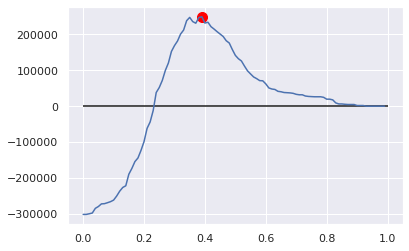

Maximum benefit at cutoff 0.39 with revenue delta of $248,870.80


In [188]:
pred_col = 'pred_rf_churn'
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(sub_df, THRESH=cutoff, discount_factor=0.2, pred_col=pred_col) for cutoff in np.arange(0, 1, 0.01)})

plot_tradeoffs(rev_deltas)

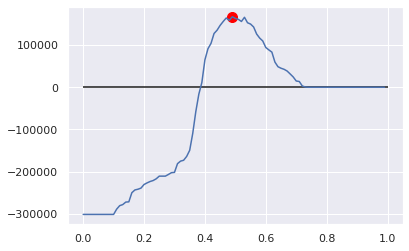

Maximum benefit at cutoff 0.49 with revenue delta of $166,999.29


In [189]:
pred_col = 'pred_xgb_churn'

# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(sub_df, THRESH=cutoff, discount_factor=0.2, pred_col=pred_col) for cutoff in np.arange(0, 1, 0.01)})

plot_tradeoffs(rev_deltas)

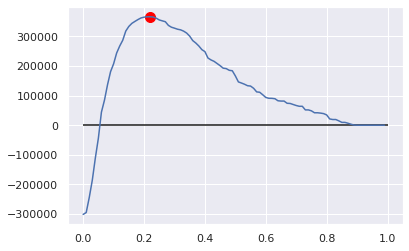

Maximum benefit at cutoff 0.22 with revenue delta of $366,291.02


In [190]:
pred_col = 'pred_lgb_churn'

# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(sub_df, THRESH=cutoff, discount_factor=0.2, pred_col=pred_col) for cutoff in np.arange(0, 1, 0.01)})

plot_tradeoffs(rev_deltas)